# Assignment 1

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

In [24]:
df1 = pd.read_csv("otto_dataset.csv", index_col=0)
df1 = df1.rename(columns={"target":"Class"})
df1 = df1[df1.Class.isin(["Class_2","Class_6","Class_8","Class_3"])]

df2 = pd.read_csv("eeg_dataset.csv")

### Split data into training and testing
For most parts, cross validation is used for model training.
However when training is time-consuming, training and testing data split in this section is used.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve

RANDOM_SEED = 216

# df1
df1 = df1.reset_index(drop=True)
df1 = shuffle(df1)
df1.Class = df1.Class.replace({'Class_2':0,'Class_3':1,'Class_6':2,'Class_8':3})
y1 = df1.Class
X1 = df1.drop(columns="Class")
# randomly pick 40 features to reduce computation time
col_idx = np.arange(X1.shape[1])
np.random.seed(seed=RANDOM_SEED)
col_idx = np.random.permutation(col_idx)
X1 = X1.iloc[:, col_idx[:40]]

cols = X1.columns
X1 = StandardScaler().fit_transform(X1)
X1 = pd.DataFrame(X1, columns=cols)

Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, y1, test_size=0.2, random_state=RANDOM_SEED)

# df2
df2 = df2.rename(columns={"y":"Class"})

df2 = shuffle(df2)
y2 = df2.Class
X2 = df2.drop(columns="Class")

cols = X2.columns
X2 = StandardScaler().fit_transform(X2)
X2 = pd.DataFrame(X2, columns=cols)

Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y2, test_size=0.2, random_state=RANDOM_SEED)

### EDA (optional)

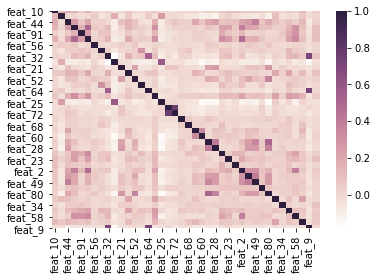

In [6]:
# plt.figure(figsize=(8,6))
corr = X1.corr()
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(corr, cmap=cmap)
plt.show()

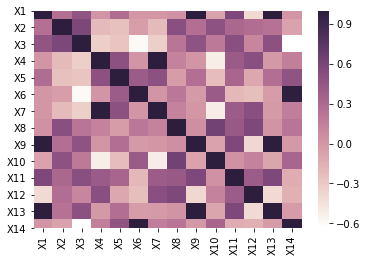

In [7]:
corr = X2.corr()
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(corr, cmap=cmap)
plt.show()

### Basic settings
define some utility functions here

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import log_loss, zero_one_loss


def conf_matrix(result):
    """
    plot confusion matrix
    
    params:
        results: confusion matrix
    
    returns:
        None
    """
    plt.figure(figsize=(6,5))
    sns.heatmap(result, cmap=cmap, annot=True, fmt="d")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.show()
    
def cal_validation_score(param, val_list, param_dict, model, Xtrain, ytrain, Xtest, ytest):
    """
    calculate training and testing accuracy scores and loss
    
    params:
        param_dict: model base parameter dictionary
        param: parameter for update
        val_list: list of values of param
        model: model class
        Xtrain: X for training
        ytrain: y for training
        Xtest: X for testing
        ytest: y for testing
    
    returns:
        train_acc: training accuracy score
        train_loss: training loss
        test_acc: testing accuracy score
        test_loss: testing loss
    """
    train_acc, train_loss, test_acc, test_loss = [], [], [], []
    for val in val_list:
        param_dict.update({param:val})
        clf = model(**param_dict)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtrain)
        train_acc.append(accuracy_score(ytrain, ypred))
        train_loss.append(zero_one_loss(ytrain, ypred))
        ypred = clf.predict(Xtest)
        test_acc.append(accuracy_score(ytest, ypred))
        test_loss.append(zero_one_loss(ytest, ypred))
    return train_acc, train_loss, test_acc, test_loss

def plot_match1(train_acc, train_loss, test_acc, test_loss, xval, title, loss=True):
    """
    plot accuracy and loss
    
    params:
        train_acc: training accuracy score
        train_loss: training loss
        test_acc: testing accuracy score
        test_loss: testing loss
        xval: value for x axis
        title: plot title
        loss: whether to plot loss function
        
    returns:
        None
    """
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(xval, train_acc, label="training accuracy")
    plt.plot(xval, test_acc, label="testing accuracy")
    plt.title(title)
#     plt.xlabel("number of iterations")
    plt.ylabel("accuracy")
    plt.legend(loc="best")
    
    if loss:
        plt.subplot(1,2,2)
        plt.plot(xval, train_loss, label="training loss")
        plt.plot(xval, test_loss, label="testing loss")
        plt.title(title)
#         plt.xlabel("number of iterations")
        plt.ylabel("loss function")
        plt.legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    return None

### Decision Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier
param_dict = {'criterion':'gini',
             'min_samples_split':3,
             'min_samples_leaf':2,
             'max_features':'auto'}
DTree = DecisionTreeClassifier(**param_dict)

#### Test the effect of tree depth on training and testing
Otto dataset

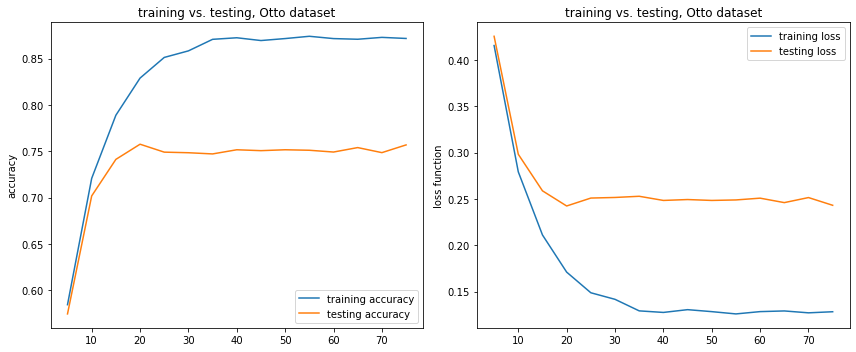

In [29]:
# test max depth of tree branches
# Otto
val_list = np.arange(5,80,5)

train1_acc_DT, train1_loss_DT, test1_acc_DT, test1_loss_DT = cal_validation_score(param="max_depth",
                                                                                 val_list=val_list,
                                                                                 param_dict=param_dict,
                                                                                 model=DecisionTreeClassifier,
                                                                                 Xtrain=Xtrain1,
                                                                                 ytrain=ytrain1,
                                                                                 Xtest=Xtest1,
                                                                                 ytest=ytest1)
plot_match1(train1_acc_DT, train1_loss_DT, test1_acc_DT, test1_loss_DT, val_list, "training vs. testing, Otto dataset")

EEG dataset

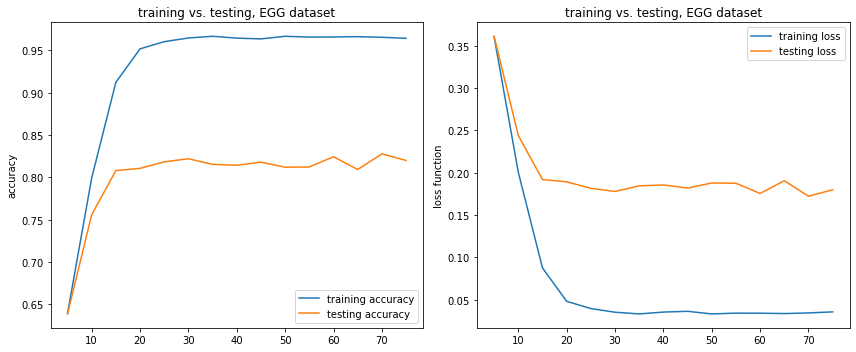

In [31]:
# test max depth of tree branches
# EEG
train2_acc_DT, train2_loss_DT, test2_acc_DT, test2_loss_DT = cal_validation_score(param="max_depth",
                                                                                 val_list=val_list,
                                                                                 param_dict=param_dict,
                                                                                 model=DecisionTreeClassifier,
                                                                                 Xtrain=Xtrain2,
                                                                                 ytrain=ytrain2,
                                                                                 Xtest=Xtest2,
                                                                                 ytest=ytest2)
plot_match1(train2_acc_DT, train2_loss_DT, test2_acc_DT, test2_loss_DT, val_list, "training vs. testing, EEG dataset")

#### Test the effect of training and testing split
Otto dataset

In [ ]:
### Effect of training and testing split
# Otto
param_dict = {'criterion':'gini',
             'min_samples_split':3,
             'min_samples_leaf':2,
             'max_features':'auto',
             'max_depth': 20}
DTree = DecisionTreeClassifier(**param_dict)
training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1, train_size=tr, random_state=RANDOM_SEED)
    DTree.fit(Xtrain, ytrain)
    train_score.append(accuracy_score(ytrain, DTree.predict(Xtrain)))
    test_score.append(accuracy_score(ytest, DTree.predict(Xtest)))

plt.plot(training_per,train_score, label='training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, Otto dataset')
plt.show()

EEG dataset

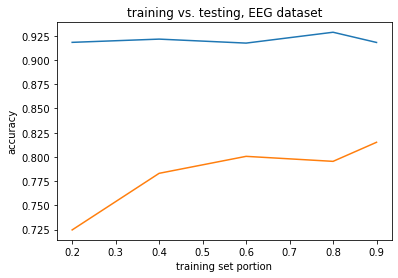

In [36]:
# Effect of training and testing split
# EEG
param_dict = {'criterion':'gini',
             'min_samples_split':3,
             'min_samples_leaf':2,
             'max_features':'auto',
             'max_depth': 15}
DTree = DecisionTreeClassifier(**param_dict)
training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, train_size=tr, random_state=RANDOM_SEED)
    DTree.fit(Xtrain, ytrain)
    train_score.append(accuracy_score(ytrain, DTree.predict(Xtrain)))
    test_score.append(accuracy_score(ytest, DTree.predict(Xtest)))

plt.plot(training_per,train_score, label=
         'training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, EEG dataset')
plt.show()

#### Confusion matrix (optional)

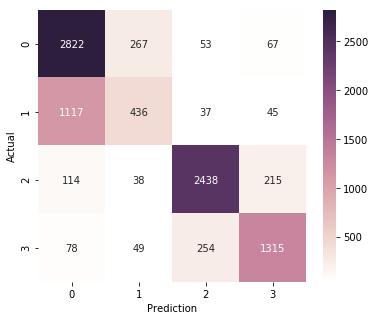

accuracy score is: 0.7502407704654895


In [14]:
# confusion matrix Otto (optional)
DTree.fit(Xtrain1,ytrain1)
ypred1_DT = DTree.predict(Xtest1)

result1_DT = confusion_matrix(ytest1, ypred1_DT)
conf_matrix(result1_DT)
print("accuracy score is: {}".format(accuracy_score(ytest1, ypred1_DT)))
# print("precision score is: {}".format(precision_score(ytest1, ypred1)))
# print("recall score is: {}".format(recall_score(ytest1, ypred1)))

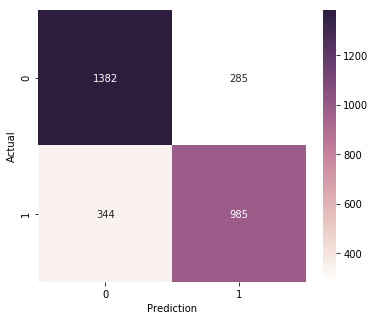

accuracy score is: 0.7900534045393859
precision score is: 0.7755905511811023
recall score is: 0.7411587659894657


In [16]:
# confusion matrix EEG (optional)
DTree.fit(Xtrain2,ytrain2)
ypred2_DT = DTree.predict(Xtest2)

result2_DT = confusion_matrix(ytest2, ypred2_DT)
conf_matrix(result2_DT)
print("accuracy score is: {}".format(accuracy_score(ytest2, ypred2_DT)))
print("precision score is: {}".format(precision_score(ytest2, ypred2_DT)))
print("recall score is: {}".format(recall_score(ytest2, ypred2_DT)))

### Boosting
utility functions defined in previous section cannot be directly implemented here.
Therefore utility funcs for Boosting are defined.

In [18]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss, zero_one_loss

def cal_accuracy(model, Xtrain, Xtest, ytrain, ytest, loss=True):
    """
    calculate accuracy and loss for each training stage
    
    params:
        model: model with pre-trained stage object
        Xtrain: X for training
        Xtest: X for testing
        ytrain: y for training
        ytest: y for testing
        loss: whether to calculate loss function
    
    returns:
        train_acc: training accuracy score
        train_loss: training loss
        test_acc: testing accuracy score
        test_loss: testing loss
    """
    train_acc, train_loss, test_acc, test_loss = [], [], [], []
    for ypred in model.staged_predict(Xtrain):
        train_acc.append(accuracy_score(ytrain, ypred))
        if loss: train_loss.append(zero_one_loss(ytrain, ypred))
    for ypred in model.staged_predict(Xtest):
        test_acc.append(accuracy_score(ytest, ypred))
        if loss: test_loss.append(zero_one_loss(ytest, ypred))
    return train_acc, train_loss, test_acc, test_loss

def plot_match2(train_acc, train_loss, test_acc, test_loss, title, loss=True):
    """
    plot accuracy and loss
    
    params:
        train_acc: training accuracy score
        train_loss: training loss
        test_acc: testing accuracy score
        test_loss: testing loss
        xval: value for x axis
        title: plot title
        loss: whether to plot loss function
        
    returns:
        None
    """
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_acc, label="training accuracy")
    plt.plot(test_acc, label="testing accuracy")
    plt.title(title)
    plt.xlabel("number of iterations")
    plt.ylabel("accuracy")
    plt.legend(loc="best")
    
    if loss:
        plt.subplot(1,2,2)
        plt.plot(train_loss, label="training loss")
        plt.plot(test_loss, label="testing loss")
        plt.title(title)
        plt.xlabel("number of iterations")
        plt.ylabel("loss function")
        plt.legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    return None

RANDOM_SEED = 216
GBoost1 = GradientBoostingClassifier(n_estimators=300,
                                   max_depth=3,
                                   random_state=RANDOM_SEED,
                                   verbose=1,
                                   )

GBoost2 = GradientBoostingClassifier(n_estimators=1200,
                                   max_depth=3,
                                   random_state=RANDOM_SEED,
                                   )

#### Test the effect of number of iteration
Otto dataset

      Iter       Train Loss   Remaining Time 
         1       46106.5021            1.27m
         2       43052.1763            1.26m
         3       40579.0040            1.26m
         4       38532.9086            1.26m
         5       36768.2444            1.27m
         6       35222.4668            1.26m
         7       33882.2908            1.26m
         8       32716.3131            1.25m
         9       31713.2437            1.25m
        10       30797.3856            1.26m
        20       24880.0327            1.23m
        30       22089.8215            1.18m
        40       20540.1126            1.13m
        50       19479.4219            1.08m
        60       18701.9331            1.03m
        70       18110.5049           59.28s
        80       17668.5625           56.26s
        90       17295.0079           53.28s
       100       16972.6923           50.54s
       200       15265.3692           23.93s
       300       14466.6343            0.00s


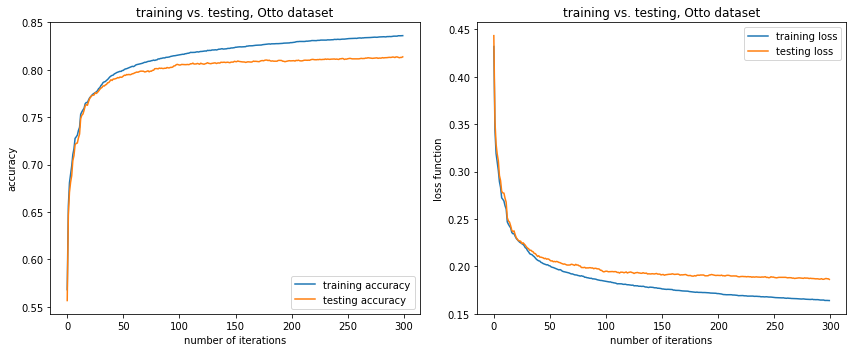

In [18]:
# learning curve
# Otto
GBoost1.fit(Xtrain1, ytrain1)
train1_acc_GB, train1_loss_GB, test1_acc_GB, test1_loss_GB = cal_accuracy(GBoost1, Xtrain1, Xtest1, ytrain1, ytest1, loss=True)
plot_match2(train1_acc_GB, train1_loss_GB, test1_acc_GB, test1_loss_GB, "training vs. testing, Otto dataset", loss=True)

EEG dataset

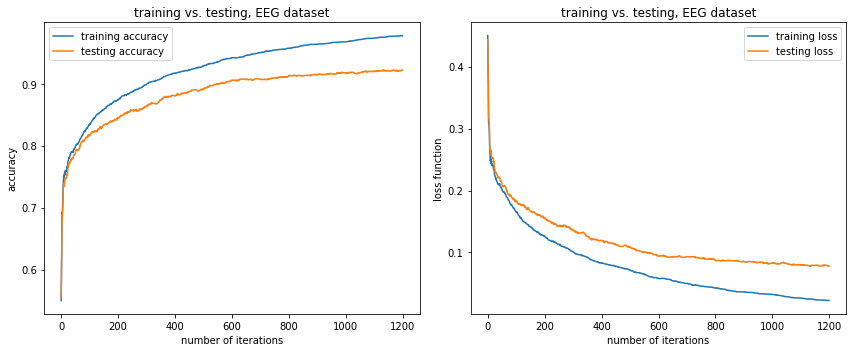

In [52]:
# learning curve
# EEG
GBoost2.fit(Xtrain2, ytrain2)
train2_acc_GB, train2_loss_GB, test2_acc_GB, test2_loss_GB = cal_accuracy(GBoost2, Xtrain2, Xtest2, ytrain2, ytest2)
plot_match2(train2_acc_GB, train2_loss_GB, test2_acc_GB, test2_loss_GB, "training vs. testing, EEG dataset")

#### Test the effect of maximal tree depth
Otto dataset

      Iter       Train Loss   Remaining Time 
         1       46106.5021           12.80s
         2       43052.1763           12.30s
         3       40579.0040           12.08s
         4       38532.9086           11.94s
         5       36768.2444           11.70s
         6       35222.4668           11.40s
         7       33882.2908           11.24s
         8       32716.3131           11.08s
         9       31713.2437           10.80s
        10       30797.3856           10.64s
        20       24880.0327            8.43s
        30       22089.8215            5.59s
        40       20540.1126            2.74s
        50       19479.4219            0.00s
      Iter       Train Loss   Remaining Time 
         1       44019.5544            2.02m
         2       39479.6060            2.34m
         3       35850.4696            2.50m
         4       32836.8668            2.59m
         5       30368.4151            2.57m
         6       28222.0234            2.55m
        

Text(0.5,0,'tree depth')

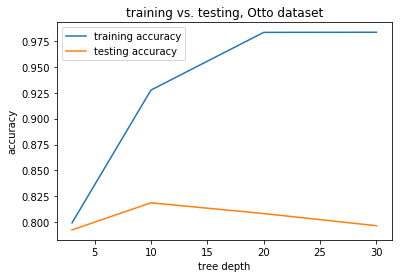

In [28]:
# analyse effect of max_depth
# Otto
RANDOM_SEED = 216
depth_list = [3,10,20,30]
train_acc, test_acc = [], []
for depth in depth_list:
    GBoost1 = GradientBoostingClassifier(n_estimators=50,
                                       max_depth=depth,
                                       random_state=RANDOM_SEED,
                                       verbose=1,
                                       )
    GBoost1.fit(Xtrain1, ytrain1)
    train_acc.append(accuracy_score(ytrain1, GBoost1.predict(Xtrain1)))
    test_acc.append(accuracy_score(ytest1, GBoost1.predict(Xtest1)))
plt.plot(depth_list, train_acc, label="training accuracy")
plt.plot(depth_list, test_acc, label="testing accuracy")
plt.title("training vs. testing, Otto dataset")
plt.ylabel("accuracy")
plt.legend()
plt.xlabel("tree depth")

EEG dataset

      Iter       Train Loss   Remaining Time 
         1           1.3490            7.17s
         2           1.3247            7.56s
         3           1.3035            7.42s
         4           1.2821            7.34s
         5           1.2654            7.29s
         6           1.2495            7.13s
         7           1.2323            7.12s
         8           1.2152            7.11s
         9           1.1998            7.01s
        10           1.1877            6.70s
        20           1.0971            5.88s
        30           1.0377            5.75s
        40           0.9957            5.71s
        50           0.9597            5.56s
        60           0.9323            5.42s
        70           0.9034            5.39s
        80           0.8792            5.41s
        90           0.8573            5.43s
       100           0.8368            5.33s
       200           0.6861            4.64s
       300           0.5888            3.80s
       40

Text(0.5, 0, 'tree depth')

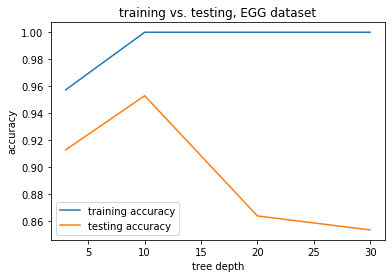

In [37]:
# analyse effect of max_depth
# EEG
RANDOM_SEED = 200
depth_list = [3,10,20,30]
train_acc, test_acc = [], []
for depth in depth_list:
    GBoost2 = GradientBoostingClassifier(n_estimators=800,
                                       max_depth=depth,
                                       random_state=RANDOM_SEED,
                                       verbose=1,
                                       )
    GBoost2.fit(Xtrain2, ytrain2)
    train_acc.append(accuracy_score(ytrain2, GBoost2.predict(Xtrain2)))
    test_acc.append(accuracy_score(ytest2, GBoost2.predict(Xtest2)))
plt.plot(depth_list, train_acc, label="training accuracy")
plt.plot(depth_list, test_acc, label="testing accuracy")
plt.title("training vs. testing, EEG dataset")
plt.ylabel("accuracy")
plt.legend()
plt.xlabel("tree depth")

#### Test the effect of training and testing split
Otto dataset

      Iter       Train Loss   Remaining Time 
         1       11510.9004           17.30s
         2       10732.5842           17.39s
         3       10113.4909           16.98s
         4        9584.4045           17.64s
         5        9154.9186           17.36s
         6        8762.7077           17.30s
         7        8411.4664           17.28s
         8        8104.4793           17.55s
         9        7849.9694           17.41s
        10        7615.9070           17.30s
        20        6121.8227           16.73s
        30        5402.2265           16.68s
        40        4987.1973           15.93s
        50        4690.9839           15.18s
        60        4480.8454           14.37s
        70        4305.5194           13.55s
        80        4170.7801           12.78s
        90        4049.0297           12.00s
       100        3951.9009           11.34s
       200        3379.5701            5.33s
       300        3080.2034            0.00s
      Ite

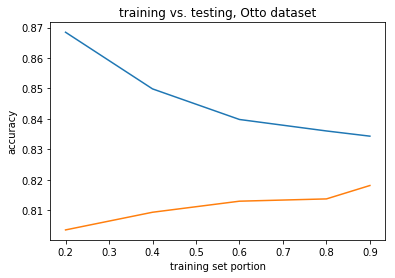

In [29]:
# Effect of training and testing split
# Otto
GBoost1 = GradientBoostingClassifier(n_estimators=300,
                                   max_depth=3,
                                   random_state=RANDOM_SEED,
                                   verbose=1,
                                   )
training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1, train_size=tr, random_state=RANDOM_SEED)
    GBoost1.fit(Xtrain, ytrain)
    train_score.append(accuracy_score(ytrain, GBoost1.predict(Xtrain)))
    test_score.append(accuracy_score(ytest, GBoost1.predict(Xtest)))

plt.plot(training_per,train_score, label='training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, EEG dataset')
plt.show()

EEG dataset

      Iter       Train Loss   Remaining Time 
         1           1.3365            4.81s
         2           1.3096            4.78s
         3           1.2842            5.17s
         4           1.2640            5.08s
         5           1.2440            5.01s
         6           1.2264            4.77s
         7           1.2094            4.59s
         8           1.1945            4.46s
         9           1.1832            4.36s
        10           1.1662            4.40s
        20           1.0631            3.77s
        30           0.9982            3.46s
        40           0.9447            3.36s
        50           0.9006            3.26s
        60           0.8588            3.18s
        70           0.8265            3.09s
        80           0.7964            3.07s
        90           0.7696            3.01s
       100           0.7430            2.97s
       200           0.5487            2.67s
       300           0.4203            2.44s
       40

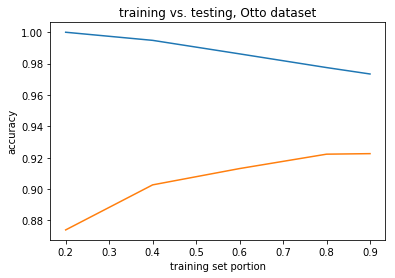

In [31]:
# Effect of training and testing split
# EEG
GBoost2 = GradientBoostingClassifier(n_estimators=1200,
                                   max_depth=3,
                                   random_state=RANDOM_SEED,
                                   verbose=1,
                                   )
training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, train_size=tr, random_state=RANDOM_SEED)
    GBoost2.fit(Xtrain, ytrain)
    train_score.append(accuracy_score(ytrain, GBoost2.predict(Xtrain)))
    test_score.append(accuracy_score(ytest, GBoost2.predict(Xtest)))

plt.plot(training_per,train_score, label='training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, Otto dataset')
plt.show()

### Support Vector Machines
For SVM, RBF and linear kernels are tested. To change kernel, you may use `param_dict` below.

In [50]:
from sklearn.svm import SVC

param_dict = {'kernel': "linear",
           'gamma': "auto",
           'degree': 2,
           'verbose': 1,
           'C': 80,
            'max_iter': 1000000}
SVM1 = SVC(**param_dict)
SVM2 = SVC(**param_dict)

### Test the effect of penalty
Otto dataset.

**Note that model training for Otto dataset did not complete due to large training time required.**

In [ ]:
# test max depth of tree branches
val_list = np.arange(20,160,20)

train1_acc_SVM, train1_loss_SVM, test1_acc_SVM, test1_loss_SVM = cal_validation_score(param="C",
                                                                                 val_list=val_list,
                                                                                 param_list=param_dict,
                                                                                 model=SVC,
                                                                                 Xtrain=Xtrain1,
                                                                                 ytrain=ytrain1,
                                                                                 Xtest=Xtest1,
                                                                                 ytest=ytest1)
plot_match1(train1_acc_SVM, train1_loss_SVM, test1_acc_SVM, test1_loss_SVM, val_list, "training vs. testing, Otto dataset")

EEG dataset

In [9]:
val_list = np.arange(10,10000,1000)
train2_acc_SVM, train2_loss_SVM, test2_acc_SVM, test2_loss_SVM = cal_validation_score(param="C",
                                                                                 val_list=val_list,
                                                                                 param_list=param_dict,
                                                                                 model=SVC,
                                                                                 Xtrain=Xtrain2,
                                                                                 ytrain=ytrain2,
                                                                                 Xtest=Xtest2,
                                                                                 ytest=ytest2)
plot_match1(train2_acc_SVM, train2_loss_SVM, test2_acc_SVM, test2_loss_SVM, val_list, "training vs. testing, EEG dataset")

[LibSVM][LibSVM][LibSVM][LibSVM]

KeyboardInterrupt: 

#### Test the effect of penalty
Otto dataset

The following graph is created using a constraint maximal iteration of 1,000,000.
It turns out that the results are not converged and difficult to interpret.

[LibSVM]

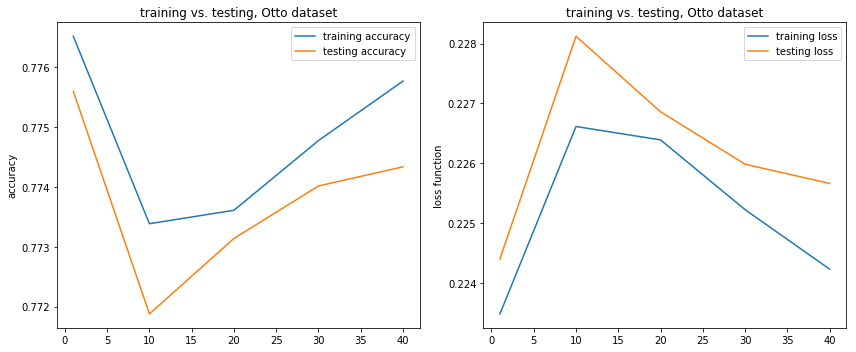

In [8]:
"""Grid search for best params"""
params = {"C":[1,10,20,30,40]}
# Otto
GS_SVM1 = GridSearchCV(SVM1, param_grid=params, scoring="accuracy", n_jobs=-1, cv=3, return_train_score=True)
GS_SVM1.fit(X1, y1)
train1_acc_SVM = GS_SVM1.cv_results_['mean_train_score']
train1_loss_SVM = 1-train1_acc_SVM
test1_acc_SVM = GS_SVM1.cv_results_['mean_test_score']
test1_loss_SVM = 1-test1_acc_SVM
plot_match1(train1_acc_SVM, train1_loss_SVM, test1_acc_SVM, test1_loss_SVM, params['C'], "training vs. testing, Otto dataset")

EEG dataset

[LibSVM]

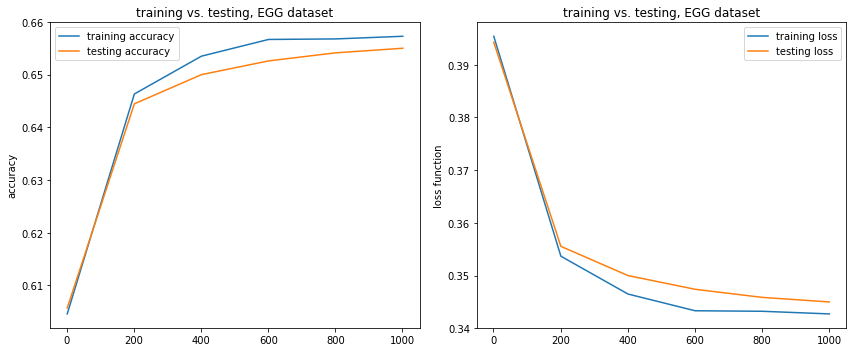

In [30]:
params = {"C": np.arange(1,1201,200)}
# EEG
GS_SVM2 = GridSearchCV(SVM2, param_grid=params, scoring="accuracy", n_jobs=-1, cv=3, return_train_score=True)
GS_SVM2.fit(X2, y2)
train2_acc_SVM = GS_SVM2.cv_results_['mean_train_score']
train2_loss_SVM = 1-train2_acc_SVM
test2_acc_SVM = GS_SVM2.cv_results_['mean_test_score']
test2_loss_SVM = 1-test2_acc_SVM
plot_match1(train2_acc_SVM, train2_loss_SVM, test2_acc_SVM, test2_loss_SVM, params['C'], "training vs. testing, EEG dataset")

#### Test the effect of training and testing split
Linear kernel

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

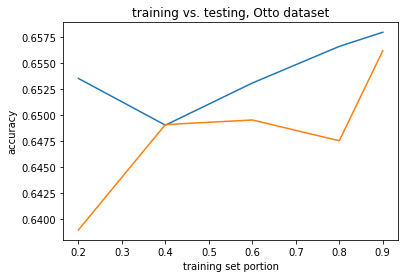

In [52]:
# Effect of training and testing split
# EEG, Linear kernel
param_dict = {'kernel': "linear",
           'gamma': "auto",
           'degree': 2,
           'verbose': 1,
           'C': 600,
           }
SVM2 = SVC(**param_dict)

training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, train_size=tr, random_state=RANDOM_SEED)
    SVM2.fit(Xtrain, ytrain)
    train_score.append(accuracy_score(ytrain, SVM2.predict(Xtrain)))
    test_score.append(accuracy_score(ytest, SVM2.predict(Xtest)))

plt.plot(training_per,train_score, label='training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, linear kernel, EEG dataset')
plt.show()

RBF kernel

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

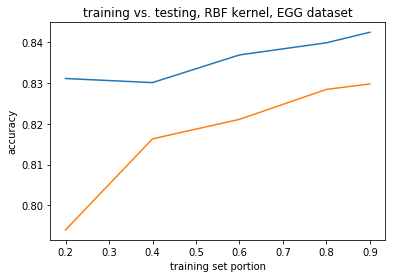

In [56]:
# Effect of training and testing split
# EEG, RBF kernel
param_dict = {'kernel': "rbf",
           'gamma': "auto",
           'degree': 2,
           'verbose': 1,
           'C': 4000,
           }
SVM2 = SVC(**param_dict)

training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, train_size=tr, random_state=RANDOM_SEED)
    SVM2.fit(Xtrain, ytrain)
    train_score.append(accuracy_score(ytrain, SVM2.predict(Xtrain)))
    test_score.append(accuracy_score(ytest, SVM2.predict(Xtest)))

plt.plot(training_per,train_score, label='training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, RBF kernel, EEG dataset')
plt.show()

#### Confusion matrix (optional)

In [ ]:
param_dict.update(GS_SVM1.best_params_)
SVM1 = SVC(**param_dict)
SVM1.fit(Xtrain1, ytrain1)
ypred1_svm = SVM1.predict(Xtest1)
results1_svm = confusion_matrix(ytest1, ypred1_svm)
conf_matrix(results1_svm)

print("accuracy score is: {}".format(accuracy_score(ytest2, ypred2_svm)))
# print("precision score is: {}".format(precision_score(ytest2, ypred2_svm)))
# print("recall score is: {}".format(recall_score(ytest2, ypred2_svm)))

[LibSVM]

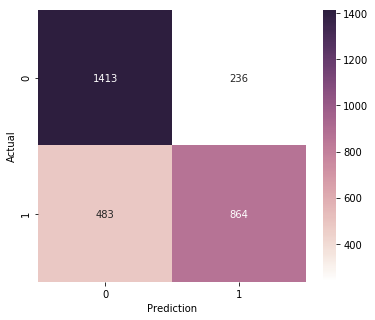

accuracy score is: 0.7600133511348465
precision score is: 0.7854545454545454
recall score is: 0.6414253897550112


In [53]:
param_dict.update(GS_SVM2.best_params_)
SVM2 = SVC(**param_dict)
SVM2.fit(Xtrain2, ytrain2)
ypred2_svm = SVM2.predict(Xtest2)
results2_svm = confusion_matrix(ytest2, ypred2_svm)
conf_matrix(results2_svm)

print("accuracy score is: {}".format(accuracy_score(ytest2, ypred2_svm)))
print("precision score is: {}".format(precision_score(ytest2, ypred2_svm)))
print("recall score is: {}".format(recall_score(ytest2, ypred2_svm)))

### K Nearest Neighbors

In [8]:
from sklearn.neighbors import KNeighborsClassifier
param_dict = {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}

KNN1 = KNeighborsClassifier(**param_dict)
KNN2 = KNeighborsClassifier(**param_dict)

### Test the effect of number of neighbors 
both datasets

In [9]:
"""Grid search for different neighbor numbers"""
params = {"n_neighbors":[4,6,8,12,16]}

# Otto
GS_KNN1 = GridSearchCV(KNN1, param_grid=params, cv=5, n_jobs=-1, scoring="accuracy", return_train_score=True)
GS_KNN1.fit(X1, y1)
print("best params for Otto dataset: {}".format(GS_KNN1.best_params_))
print("best recall score Otto dataset: {}".format(GS_KNN1.best_score_))

# EEG
GS_KNN2 = GridSearchCV(KNN2, param_grid=params, cv=5, n_jobs=-1, scoring="accuracy", return_train_score=True)
GS_KNN2.fit(X2, y2)
print("best params for EEG dataset: {}".format(GS_KNN2.best_params_))
print("best recall score EEG dataset: {}".format(GS_KNN2.best_score_))

best params for Otto dataset: {'n_neighbors': 12}
best recall score Otto dataset: 0.7936008560727662
best params for EGG dataset: {'n_neighbors': 4}
best recall score EGG dataset: 0.8288384512683578


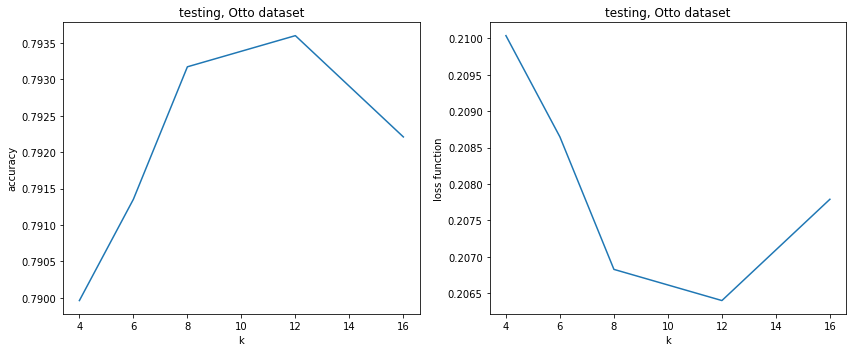

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(GS_KNN1.cv_results_['param_n_neighbors'].data, GS_KNN1.cv_results_['mean_test_score'])
plt.title("testing, Otto dataset")
plt.xlabel("k")
plt.ylabel("accuracy")

plt.subplot(1,2,2)
plt.plot(GS_KNN1.cv_results_['param_n_neighbors'].data, 1-GS_KNN1.cv_results_['mean_test_score'])
plt.title("testing, Otto dataset")
plt.xlabel("k")
plt.ylabel("loss function")
plt.tight_layout()
plt.show()

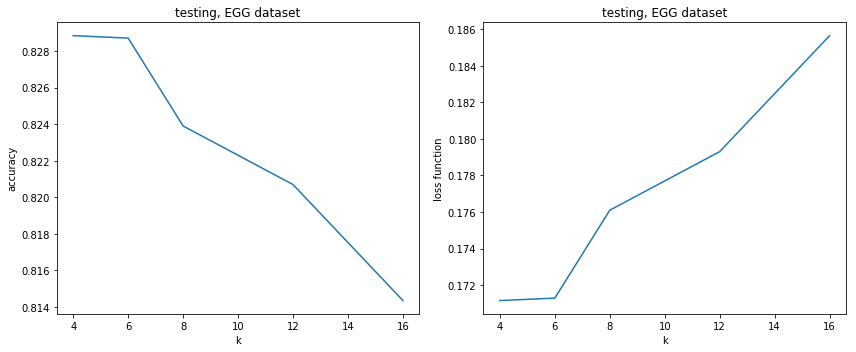

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(GS_KNN2.cv_results_['param_n_neighbors'].data, GS_KNN2.cv_results_['mean_test_score'])
plt.title("testing, EEG dataset")
plt.xlabel("k")
plt.ylabel("accuracy")

plt.subplot(1,2,2)
plt.plot(GS_KNN2.cv_results_['param_n_neighbors'].data, 1-GS_KNN2.cv_results_['mean_test_score'])
plt.title("testing, EEG dataset")
plt.xlabel("k")
plt.ylabel("loss function")
plt.tight_layout()
plt.show()

### Confusion matrix (optional)

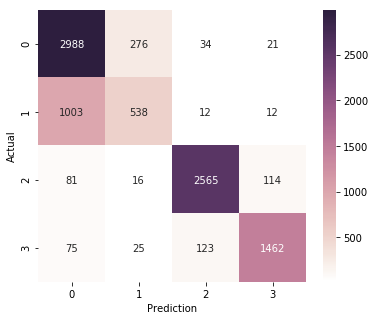

accuracy score is: 0.8082397003745319


In [93]:
param_dict.update(GS_KNN1.best_params_)
KNN1 = KNeighborsClassifier(**param_dict)
KNN1.fit(Xtrain1, ytrain1)
ypred1_knn = KNN1.predict(Xtest1)
results1_knn = confusion_matrix(ytest1, ypred1_knn)
conf_matrix(results1_knn)

print("accuracy score is: {}".format(accuracy_score(ytest1, ypred1_knn)))
# print("precision score is: {}".format(precision_score(ytest2, ypred2_svm)))
# print("recall score is: {}".format(recall_score(ytest2, ypred2_svm)))

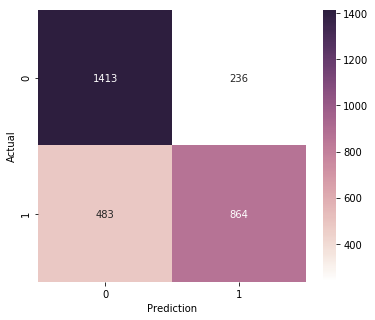

accuracy score is: 0.8267690253671562
precision score is: 0.8183925811437404
recall score is: 0.7885331347728965


In [94]:
param_dict.update(GS_KNN2.best_params_)
KNN2 = KNeighborsClassifier(**param_dict)
KNN2.fit(Xtrain2, ytrain2)
ypred2_knn = KNN2.predict(Xtest2)
results2_knn = confusion_matrix(ytest2, ypred2_knn)
conf_matrix(results2_svm)

print("accuracy score is: {}".format(accuracy_score(ytest2, ypred2_knn)))
print("precision score is: {}".format(precision_score(ytest2, ypred2_knn)))
print("recall score is: {}".format(recall_score(ytest2, ypred2_knn)))

### Neural Network
define some utility functions for neural network

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

def create_neural_net(category=4, dim=40):
    model = Sequential()
    model.add(Dense(1024, input_dim=dim, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(category, activation="sigmoid"))
    return model

def plot_DNN(model):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(model.history.history['acc'], label="training accuracy")
    plt.plot(model.history.history['val_acc'], label="testing accuracy")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")

    plt.subplot(1,2,2)
    plt.plot(model.history.history['loss'], label="training loss")
    plt.plot(model.history.history['val_loss'], label="testing loss")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("loss function")
    plt.tight_layout()
    plt.show()
    
    return None

Using TensorFlow backend.
C:\Users\yao_p\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yao_p\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yao_p\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yao_p\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Test the effect of iterations
Otto dataset

In [16]:
# learning curve
# Otto
DNN1 = create_neural_net(category=4, dim=Xtrain1.shape[1])
callbacks = [EarlyStopping(monitor="loss", patience=10, mode="min")]
DNN1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
DNN1.fit(Xtrain1, ytrain1, epochs=300, batch_size=10000, validation_data=(Xtest1, ytest1), callbacks=callbacks)

Train on 37380 samples, validate on 9345 samples
Epoch 1/300
37380/37380 [==============================] - 3s 87us/step - loss: 1.3505 - acc: 0.4223 - val_loss: 1.2048 - val_acc: 0.6919
Epoch 2/300
37380/37380 [==============================] - 0s 5us/step - loss: 1.1340 - acc: 0.6517 - val_loss: 0.9174 - val_acc: 0.7287
Epoch 3/300
37380/37380 [==============================] - 0s 5us/step - loss: 0.8951 - acc: 0.6937 - val_loss: 0.6779 - val_acc: 0.7490
Epoch 4/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.7463 - acc: 0.7140 - val_loss: 0.5962 - val_acc: 0.7662
Epoch 5/300
37380/37380 [==============================] - 0s 5us/step - loss: 0.6670 - acc: 0.7411 - val_loss: 0.5686 - val_acc: 0.7711
Epoch 6/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.6227 - acc: 0.7578 - val_loss: 0.5417 - val_acc: 0.7724
Epoch 7/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.5861 - acc: 0.7654 - val_loss: 0.5180 - val_acc

37380/37380 [==============================] - 0s 7us/step - loss: 0.3851 - acc: 0.8231 - val_loss: 0.4251 - val_acc: 0.8066
Epoch 61/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.3821 - acc: 0.8245 - val_loss: 0.4277 - val_acc: 0.8078
Epoch 62/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.3808 - acc: 0.8255 - val_loss: 0.4276 - val_acc: 0.8086
Epoch 63/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.3798 - acc: 0.8272 - val_loss: 0.4289 - val_acc: 0.8087
Epoch 64/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.3777 - acc: 0.8272 - val_loss: 0.4268 - val_acc: 0.8106
Epoch 65/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.3800 - acc: 0.8257 - val_loss: 0.4261 - val_acc: 0.8122
Epoch 66/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.3792 - acc: 0.8280 - val_loss: 0.4309 - val_acc: 0.8102
Epoch 67/300
37380/37380 [=====================

37380/37380 [==============================] - 0s 6us/step - loss: 0.2787 - acc: 0.8735 - val_loss: 0.4836 - val_acc: 0.8108
Epoch 179/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2827 - acc: 0.8722 - val_loss: 0.4776 - val_acc: 0.8118
Epoch 180/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2779 - acc: 0.8742 - val_loss: 0.4815 - val_acc: 0.8111
Epoch 181/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.2765 - acc: 0.8741 - val_loss: 0.4821 - val_acc: 0.8118
Epoch 182/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2763 - acc: 0.8735 - val_loss: 0.4894 - val_acc: 0.8114
Epoch 183/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2773 - acc: 0.8732 - val_loss: 0.4778 - val_acc: 0.8097
Epoch 184/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2763 - acc: 0.8743 - val_loss: 0.4814 - val_acc: 0.8149
Epoch 185/300
37380/37380 [==============

37380/37380 [==============================] - 0s 7us/step - loss: 0.2429 - acc: 0.8920 - val_loss: 0.5170 - val_acc: 0.8126
Epoch 238/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.2427 - acc: 0.8930 - val_loss: 0.5165 - val_acc: 0.8125
Epoch 239/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.2368 - acc: 0.8936 - val_loss: 0.5259 - val_acc: 0.8136
Epoch 240/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2388 - acc: 0.8933 - val_loss: 0.5239 - val_acc: 0.8148
Epoch 241/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2389 - acc: 0.8938 - val_loss: 0.5164 - val_acc: 0.8128
Epoch 242/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2380 - acc: 0.8934 - val_loss: 0.5244 - val_acc: 0.8120
Epoch 243/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.2363 - acc: 0.8946 - val_loss: 0.5249 - val_acc: 0.8090
Epoch 244/300
37380/37380 [==============

37380/37380 [==============================] - 0s 6us/step - loss: 0.2076 - acc: 0.9087 - val_loss: 0.5771 - val_acc: 0.8148
Epoch 297/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2095 - acc: 0.9093 - val_loss: 0.5603 - val_acc: 0.8135
Epoch 298/300
37380/37380 [==============================] - 0s 7us/step - loss: 0.2081 - acc: 0.9103 - val_loss: 0.5699 - val_acc: 0.8107
Epoch 299/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2070 - acc: 0.9096 - val_loss: 0.5776 - val_acc: 0.8093
Epoch 300/300
37380/37380 [==============================] - 0s 6us/step - loss: 0.2066 - acc: 0.9096 - val_loss: 0.5722 - val_acc: 0.8112


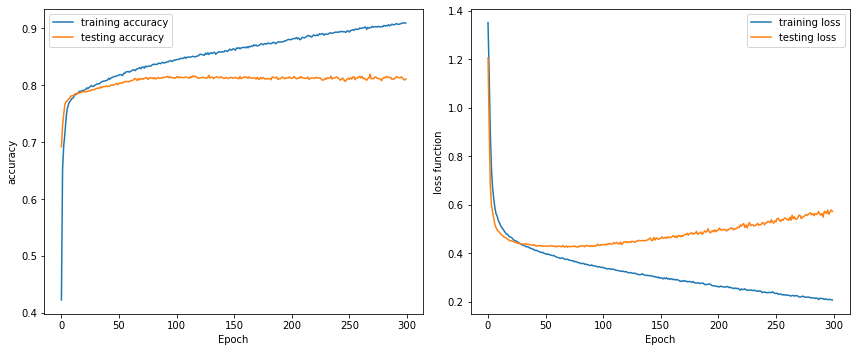

In [17]:
plot_DNN(DNN1)

EEG dataset

In [48]:
# learning curve
# EEG
DNN2 = create_neural_net(category=1, dim=Xtrain2.shape[1])
callbacks = [EarlyStopping(monitor="loss", patience=40, mode="min")]
DNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
DNN2.fit(Xtrain2, ytrain2, epochs=1200, batch_size=10000, validation_data=(Xtest2, ytest2), callbacks=callbacks)

Train on 11984 samples, validate on 2996 samples
Epoch 1/1200
11984/11984 [==============================] - 3s 231us/step - loss: 0.6894 - acc: 0.5446 - val_loss: 0.6735 - val_acc: 0.5704
Epoch 2/1200
11984/11984 [==============================] - 1s 76us/step - loss: 0.6765 - acc: 0.5687 - val_loss: 0.6620 - val_acc: 0.5751
Epoch 3/1200
11984/11984 [==============================] - 1s 75us/step - loss: 0.6678 - acc: 0.5731 - val_loss: 0.6548 - val_acc: 0.5874
Epoch 4/1200
11984/11984 [==============================] - 1s 76us/step - loss: 0.6603 - acc: 0.5847 - val_loss: 0.6527 - val_acc: 0.5928
Epoch 5/1200
11984/11984 [==============================] - 1s 80us/step - loss: 0.6550 - acc: 0.5942 - val_loss: 0.6442 - val_acc: 0.6065
Epoch 6/1200
11984/11984 [==============================] - 1s 76us/step - loss: 0.6472 - acc: 0.6058 - val_loss: 0.6371 - val_acc: 0.6138
Epoch 7/1200
11984/11984 [==============================] - 1s 77us/step - loss: 0.6437 - acc: 0.6102 - val_loss: 0.

11984/11984 [==============================] - 1s 74us/step - loss: 0.2852 - acc: 0.8758 - val_loss: 0.2999 - val_acc: 0.8695
Epoch 118/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.2781 - acc: 0.8803 - val_loss: 0.3037 - val_acc: 0.8678
Epoch 119/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.2916 - acc: 0.8714 - val_loss: 0.3016 - val_acc: 0.8708
Epoch 120/1200
11984/11984 [==============================] - 1s 75us/step - loss: 0.2802 - acc: 0.8776 - val_loss: 0.3013 - val_acc: 0.8698
Epoch 121/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.2776 - acc: 0.8826 - val_loss: 0.3003 - val_acc: 0.8722
Epoch 122/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.2721 - acc: 0.8832 - val_loss: 0.3015 - val_acc: 0.8688
Epoch 123/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.2807 - acc: 0.8798 - val_loss: 0.2979 - val_acc: 0.8662
Epoch 124/1200
11984/11984 [

11984/11984 [==============================] - 1s 77us/step - loss: 0.1588 - acc: 0.9355 - val_loss: 0.2256 - val_acc: 0.9085
Epoch 234/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.1560 - acc: 0.9384 - val_loss: 0.2282 - val_acc: 0.9052
Epoch 235/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.1605 - acc: 0.9353 - val_loss: 0.2266 - val_acc: 0.9079
Epoch 236/1200
11984/11984 [==============================] - 1s 72us/step - loss: 0.1517 - acc: 0.9376 - val_loss: 0.2225 - val_acc: 0.9105
Epoch 237/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.1575 - acc: 0.9348 - val_loss: 0.2260 - val_acc: 0.9075
Epoch 238/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.1553 - acc: 0.9388 - val_loss: 0.2393 - val_acc: 0.9022
Epoch 239/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.1611 - acc: 0.9345 - val_loss: 0.2311 - val_acc: 0.9035
Epoch 240/1200
11984/11984 [

11984/11984 [==============================] - 1s 77us/step - loss: 0.1068 - acc: 0.9597 - val_loss: 0.2235 - val_acc: 0.9246
Epoch 350/1200
11984/11984 [==============================] - 1s 76us/step - loss: 0.1060 - acc: 0.9574 - val_loss: 0.2053 - val_acc: 0.9202
Epoch 351/1200
11984/11984 [==============================] - 1s 81us/step - loss: 0.1003 - acc: 0.9599 - val_loss: 0.2221 - val_acc: 0.9212
Epoch 352/1200
11984/11984 [==============================] - 1s 75us/step - loss: 0.1019 - acc: 0.9603 - val_loss: 0.2127 - val_acc: 0.9239
Epoch 353/1200
11984/11984 [==============================] - 1s 80us/step - loss: 0.0976 - acc: 0.9603 - val_loss: 0.2110 - val_acc: 0.9192
Epoch 354/1200
11984/11984 [==============================] - 1s 88us/step - loss: 0.0937 - acc: 0.9643 - val_loss: 0.2127 - val_acc: 0.9199
Epoch 355/1200
11984/11984 [==============================] - 1s 84us/step - loss: 0.0923 - acc: 0.9654 - val_loss: 0.2101 - val_acc: 0.9189
Epoch 356/1200
11984/11984 [

11984/11984 [==============================] - 1s 75us/step - loss: 0.0519 - acc: 0.9805 - val_loss: 0.1956 - val_acc: 0.9336
Epoch 466/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.0601 - acc: 0.9776 - val_loss: 0.1976 - val_acc: 0.9312
Epoch 467/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.0516 - acc: 0.9808 - val_loss: 0.2092 - val_acc: 0.9306
Epoch 468/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.0602 - acc: 0.9780 - val_loss: 0.2107 - val_acc: 0.9269
Epoch 469/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.0593 - acc: 0.9784 - val_loss: 0.2062 - val_acc: 0.9316
Epoch 470/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.0591 - acc: 0.9774 - val_loss: 0.2191 - val_acc: 0.9256
Epoch 471/1200
11984/11984 [==============================] - 1s 73us/step - loss: 0.0602 - acc: 0.9775 - val_loss: 0.1998 - val_acc: 0.9332
Epoch 472/1200
11984/11984 [

11984/11984 [==============================] - 1s 77us/step - loss: 0.0341 - acc: 0.9877 - val_loss: 0.1980 - val_acc: 0.9383
Epoch 582/1200
11984/11984 [==============================] - 1s 77us/step - loss: 0.0381 - acc: 0.9870 - val_loss: 0.1971 - val_acc: 0.9383
Epoch 583/1200
11984/11984 [==============================] - 1s 79us/step - loss: 0.0394 - acc: 0.9867 - val_loss: 0.2066 - val_acc: 0.9362
Epoch 584/1200
11984/11984 [==============================] - 1s 74us/step - loss: 0.0421 - acc: 0.9859 - val_loss: 0.1895 - val_acc: 0.9419
Epoch 585/1200
11984/11984 [==============================] - 1s 84us/step - loss: 0.0386 - acc: 0.9867 - val_loss: 0.1965 - val_acc: 0.9396
Epoch 586/1200
11984/11984 [==============================] - 1s 80us/step - loss: 0.0337 - acc: 0.9872 - val_loss: 0.2122 - val_acc: 0.9316
Epoch 587/1200
11984/11984 [==============================] - 1s 75us/step - loss: 0.0433 - acc: 0.9851 - val_loss: 0.1987 - val_acc: 0.9386
Epoch 588/1200
11984/11984 [

11984/11984 [==============================] - 1s 84us/step - loss: 0.0301 - acc: 0.9895 - val_loss: 0.1972 - val_acc: 0.9453
Epoch 698/1200
11984/11984 [==============================] - 1s 83us/step - loss: 0.0265 - acc: 0.9908 - val_loss: 0.1963 - val_acc: 0.9446
Epoch 699/1200
11984/11984 [==============================] - 1s 80us/step - loss: 0.0254 - acc: 0.9907 - val_loss: 0.1959 - val_acc: 0.9426
Epoch 700/1200
11984/11984 [==============================] - 1s 80us/step - loss: 0.0281 - acc: 0.9892 - val_loss: 0.1965 - val_acc: 0.9433
Epoch 701/1200
11984/11984 [==============================] - 1s 76us/step - loss: 0.0239 - acc: 0.9916 - val_loss: 0.1959 - val_acc: 0.9443
Epoch 702/1200
11984/11984 [==============================] - 1s 79us/step - loss: 0.0257 - acc: 0.9902 - val_loss: 0.1958 - val_acc: 0.9426
Epoch 703/1200
11984/11984 [==============================] - 1s 82us/step - loss: 0.0259 - acc: 0.9916 - val_loss: 0.1969 - val_acc: 0.9423
Epoch 704/1200
11984/11984 [

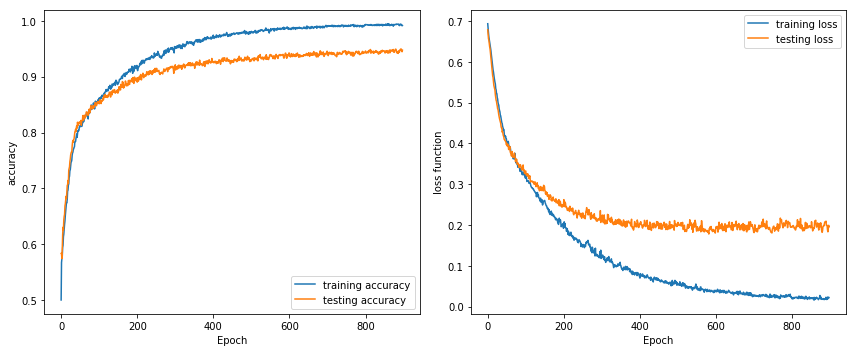

In [23]:
plot_DNN(DNN2)

### Test the effect of training and testing split
Otto dataset

Train on 9345 samples, validate on 37380 samples
Epoch 1/100
9345/9345 [==============================] - 3s 323us/step - loss: 1.3809 - acc: 0.2401 - val_loss: 1.3229 - val_acc: 0.6205
Epoch 2/100
9345/9345 [==============================] - 1s 137us/step - loss: 1.3265 - acc: 0.4680 - val_loss: 1.2548 - val_acc: 0.6783
Epoch 3/100
9345/9345 [==============================] - 1s 134us/step - loss: 1.2652 - acc: 0.5854 - val_loss: 1.1829 - val_acc: 0.6928
Epoch 4/100
9345/9345 [==============================] - 1s 135us/step - loss: 1.1998 - acc: 0.6394 - val_loss: 1.1007 - val_acc: 0.7162
Epoch 5/100
9345/9345 [==============================] - 1s 134us/step - loss: 1.1277 - acc: 0.6762 - val_loss: 1.0139 - val_acc: 0.7315
Epoch 6/100
9345/9345 [==============================] - 1s 143us/step - loss: 1.0489 - acc: 0.7059 - val_loss: 0.9263 - val_acc: 0.7392
Epoch 7/100
9345/9345 [==============================] - 1s 140us/step - loss: 0.9699 - acc: 0.7188 - val_loss: 0.8375 - val_acc:

9345/9345 [==============================] - 1s 153us/step - loss: 0.4459 - acc: 0.8022 - val_loss: 0.4647 - val_acc: 0.7920
Epoch 61/100
9345/9345 [==============================] - 1s 152us/step - loss: 0.4407 - acc: 0.8059 - val_loss: 0.4638 - val_acc: 0.7929
Epoch 62/100
9345/9345 [==============================] - 1s 151us/step - loss: 0.4422 - acc: 0.8048 - val_loss: 0.4624 - val_acc: 0.7932
Epoch 63/100
9345/9345 [==============================] - 1s 153us/step - loss: 0.4358 - acc: 0.8070 - val_loss: 0.4619 - val_acc: 0.7932
Epoch 64/100
9345/9345 [==============================] - 1s 145us/step - loss: 0.4371 - acc: 0.8059 - val_loss: 0.4617 - val_acc: 0.7927
Epoch 65/100
9345/9345 [==============================] - 1s 146us/step - loss: 0.4343 - acc: 0.8034 - val_loss: 0.4620 - val_acc: 0.7930
Epoch 66/100
9345/9345 [==============================] - 1s 139us/step - loss: 0.4368 - acc: 0.8018 - val_loss: 0.4624 - val_acc: 0.7930
Epoch 67/100
9345/9345 [=======================

18690/18690 [==============================] - 2s 95us/step - loss: 0.5064 - acc: 0.7840 - val_loss: 0.4838 - val_acc: 0.7838
Epoch 20/100
18690/18690 [==============================] - 2s 102us/step - loss: 0.5027 - acc: 0.7851 - val_loss: 0.4795 - val_acc: 0.7844
Epoch 21/100
18690/18690 [==============================] - 2s 96us/step - loss: 0.4959 - acc: 0.7887 - val_loss: 0.4762 - val_acc: 0.7857
Epoch 22/100
18690/18690 [==============================] - 2s 98us/step - loss: 0.4921 - acc: 0.7903 - val_loss: 0.4737 - val_acc: 0.7873
Epoch 23/100
18690/18690 [==============================] - 2s 130us/step - loss: 0.4886 - acc: 0.7922 - val_loss: 0.4714 - val_acc: 0.7876
Epoch 24/100
18690/18690 [==============================] - 2s 96us/step - loss: 0.4874 - acc: 0.7900 - val_loss: 0.4695 - val_acc: 0.7882
Epoch 25/100
18690/18690 [==============================] - 2s 95us/step - loss: 0.4798 - acc: 0.7918 - val_loss: 0.4682 - val_acc: 0.7886
Epoch 26/100
18690/18690 [============

Epoch 78/100
18690/18690 [==============================] - 2s 112us/step - loss: 0.3830 - acc: 0.8232 - val_loss: 0.4451 - val_acc: 0.8055
Epoch 79/100
18690/18690 [==============================] - 2s 99us/step - loss: 0.3828 - acc: 0.8253 - val_loss: 0.4456 - val_acc: 0.8086
Epoch 80/100
18690/18690 [==============================] - 2s 95us/step - loss: 0.3815 - acc: 0.8265 - val_loss: 0.4472 - val_acc: 0.8062
Epoch 81/100
18690/18690 [==============================] - 2s 95us/step - loss: 0.3806 - acc: 0.8264 - val_loss: 0.4468 - val_acc: 0.8075
Epoch 82/100
18690/18690 [==============================] - 2s 96us/step - loss: 0.3791 - acc: 0.8247 - val_loss: 0.4458 - val_acc: 0.8077
Epoch 83/100
18690/18690 [==============================] - 2s 96us/step - loss: 0.3799 - acc: 0.8264 - val_loss: 0.4456 - val_acc: 0.8089
Epoch 84/100
18690/18690 [==============================] - 2s 96us/step - loss: 0.3769 - acc: 0.8284 - val_loss: 0.4451 - val_acc: 0.8085
Epoch 85/100
18690/18690 [

28035/28035 [==============================] - 2s 87us/step - loss: 0.3435 - acc: 0.8436 - val_loss: 0.4348 - val_acc: 0.8207
Epoch 96/100
28035/28035 [==============================] - 2s 82us/step - loss: 0.3428 - acc: 0.8444 - val_loss: 0.4326 - val_acc: 0.8181
Epoch 97/100
28035/28035 [==============================] - 2s 82us/step - loss: 0.3417 - acc: 0.8433 - val_loss: 0.4326 - val_acc: 0.8188
Epoch 98/100
28035/28035 [==============================] - 2s 83us/step - loss: 0.3393 - acc: 0.8462 - val_loss: 0.4338 - val_acc: 0.8193
Epoch 99/100
28035/28035 [==============================] - 2s 83us/step - loss: 0.3390 - acc: 0.8457 - val_loss: 0.4372 - val_acc: 0.8200
Epoch 100/100
28035/28035 [==============================] - 2s 84us/step - loss: 0.3397 - acc: 0.8470 - val_loss: 0.4303 - val_acc: 0.8202
Train on 37380 samples, validate on 9345 samples
Epoch 1/100
37380/37380 [==============================] - 5s 132us/step - loss: 1.3045 - acc: 0.5071 - val_loss: 1.0867 - val_ac

Epoch 54/100
37380/37380 [==============================] - 3s 76us/step - loss: 0.3938 - acc: 0.8165 - val_loss: 0.4267 - val_acc: 0.8106
Epoch 55/100
37380/37380 [==============================] - 3s 79us/step - loss: 0.3921 - acc: 0.8181 - val_loss: 0.4226 - val_acc: 0.8103
Epoch 56/100
37380/37380 [==============================] - 3s 80us/step - loss: 0.3910 - acc: 0.8183 - val_loss: 0.4240 - val_acc: 0.8117
Epoch 57/100
37380/37380 [==============================] - 3s 81us/step - loss: 0.3888 - acc: 0.8197 - val_loss: 0.4267 - val_acc: 0.8110
Epoch 58/100
37380/37380 [==============================] - 3s 85us/step - loss: 0.3878 - acc: 0.8199 - val_loss: 0.4218 - val_acc: 0.8114
Epoch 59/100
37380/37380 [==============================] - 3s 80us/step - loss: 0.3858 - acc: 0.8205 - val_loss: 0.4229 - val_acc: 0.8125
Epoch 60/100
37380/37380 [==============================] - 3s 78us/step - loss: 0.3840 - acc: 0.8239 - val_loss: 0.4241 - val_acc: 0.8121
Epoch 61/100
37380/37380 [=

42052/42052 [==============================] - 4s 86us/step - loss: 0.3634 - acc: 0.8349 - val_loss: 0.4299 - val_acc: 0.8158
Epoch 72/100
42052/42052 [==============================] - 3s 83us/step - loss: 0.3625 - acc: 0.8354 - val_loss: 0.4313 - val_acc: 0.8145
Epoch 73/100
42052/42052 [==============================] - 3s 73us/step - loss: 0.3618 - acc: 0.8353 - val_loss: 0.4256 - val_acc: 0.8190
Epoch 74/100
42052/42052 [==============================] - 3s 73us/step - loss: 0.3577 - acc: 0.8366 - val_loss: 0.4309 - val_acc: 0.8194
Epoch 75/100
42052/42052 [==============================] - 3s 76us/step - loss: 0.3586 - acc: 0.8364 - val_loss: 0.4284 - val_acc: 0.8192
Epoch 76/100
42052/42052 [==============================] - 3s 83us/step - loss: 0.3573 - acc: 0.8363 - val_loss: 0.4325 - val_acc: 0.8179
Epoch 77/100
42052/42052 [==============================] - 3s 76us/step - loss: 0.3570 - acc: 0.8358 - val_loss: 0.4313 - val_acc: 0.8194
Epoch 78/100
42052/42052 [==============

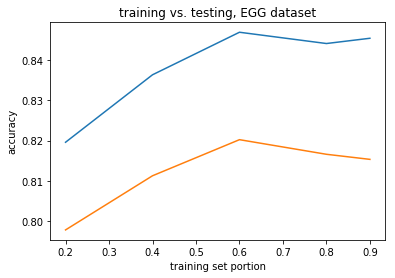

In [43]:
# Effect of training and testing split
# Otto
training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1, train_size=tr, random_state=RANDOM_SEED)
    DNN1 = create_neural_net(category=4, dim=Xtrain.shape[1])
    DNN1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    DNN1.fit(Xtrain, ytrain, epochs=100, batch_size=10000, validation_data=(Xtest, ytest))
    train_score.append(DNN1.history.history['acc'][-1])
    test_score.append(DNN1.history.history['val_acc'][-1])

plt.plot(training_per,train_score, label='training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, Otto dataset')
plt.show()

EEG dataset

Train on 2996 samples, validate on 11984 samples
Epoch 1/600
2996/2996 [==============================] - 2s 595us/step - loss: 0.7005 - acc: 0.4449 - val_loss: 0.6894 - val_acc: 0.5475
Epoch 2/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.6873 - acc: 0.5751 - val_loss: 0.6851 - val_acc: 0.5481
Epoch 3/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.6819 - acc: 0.5691 - val_loss: 0.6798 - val_acc: 0.5645
Epoch 4/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.6754 - acc: 0.5771 - val_loss: 0.6758 - val_acc: 0.5699
Epoch 5/600
2996/2996 [==============================] - 0s 135us/step - loss: 0.6734 - acc: 0.5754 - val_loss: 0.6727 - val_acc: 0.5638
Epoch 6/600
2996/2996 [==============================] - 0s 142us/step - loss: 0.6701 - acc: 0.5798 - val_loss: 0.6696 - val_acc: 0.5661
Epoch 7/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.6658 - acc: 0.5838 - val_loss: 0.6657 - val_acc:

2996/2996 [==============================] - 0s 136us/step - loss: 0.4595 - acc: 0.7790 - val_loss: 0.4785 - val_acc: 0.7628
Epoch 61/600
2996/2996 [==============================] - 0s 135us/step - loss: 0.4514 - acc: 0.7840 - val_loss: 0.4722 - val_acc: 0.7654
Epoch 62/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.4512 - acc: 0.7914 - val_loss: 0.4704 - val_acc: 0.7666
Epoch 63/600
2996/2996 [==============================] - 0s 143us/step - loss: 0.4419 - acc: 0.7894 - val_loss: 0.4654 - val_acc: 0.7706
Epoch 64/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.4428 - acc: 0.7954 - val_loss: 0.4638 - val_acc: 0.7728
Epoch 65/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.4382 - acc: 0.7977 - val_loss: 0.4624 - val_acc: 0.7727
Epoch 66/600
2996/2996 [==============================] - 0s 135us/step - loss: 0.4366 - acc: 0.7931 - val_loss: 0.4600 - val_acc: 0.7737
Epoch 67/600
2996/2996 [=======================

Epoch 120/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.2874 - acc: 0.8808 - val_loss: 0.4130 - val_acc: 0.8157
Epoch 121/600
2996/2996 [==============================] - 0s 139us/step - loss: 0.2857 - acc: 0.8722 - val_loss: 0.4157 - val_acc: 0.8163
Epoch 122/600
2996/2996 [==============================] - 0s 139us/step - loss: 0.2856 - acc: 0.8755 - val_loss: 0.4215 - val_acc: 0.8146
Epoch 123/600
2996/2996 [==============================] - 0s 139us/step - loss: 0.2906 - acc: 0.8768 - val_loss: 0.4232 - val_acc: 0.8143
Epoch 124/600
2996/2996 [==============================] - 0s 138us/step - loss: 0.2850 - acc: 0.8808 - val_loss: 0.4237 - val_acc: 0.8128
Epoch 125/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.2825 - acc: 0.8822 - val_loss: 0.4224 - val_acc: 0.8141
Epoch 126/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.2861 - acc: 0.8772 - val_loss: 0.4163 - val_acc: 0.8187
Epoch 127/600
2996/2996 [==

Epoch 179/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.2167 - acc: 0.9102 - val_loss: 0.4356 - val_acc: 0.8265
Epoch 180/600
2996/2996 [==============================] - 0s 135us/step - loss: 0.2074 - acc: 0.9156 - val_loss: 0.4266 - val_acc: 0.8313
Epoch 181/600
2996/2996 [==============================] - 0s 140us/step - loss: 0.2127 - acc: 0.9196 - val_loss: 0.4373 - val_acc: 0.8287
Epoch 182/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.2138 - acc: 0.9159 - val_loss: 0.4334 - val_acc: 0.8283
Epoch 183/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.2123 - acc: 0.9129 - val_loss: 0.4272 - val_acc: 0.8318
Epoch 184/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.1992 - acc: 0.9169 - val_loss: 0.4348 - val_acc: 0.8294
Epoch 185/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.1950 - acc: 0.9216 - val_loss: 0.4280 - val_acc: 0.8294
Epoch 186/600
2996/2996 [==

Epoch 238/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.1553 - acc: 0.9349 - val_loss: 0.4599 - val_acc: 0.8356
Epoch 239/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.1529 - acc: 0.9419 - val_loss: 0.4564 - val_acc: 0.8355
Epoch 240/600
2996/2996 [==============================] - 0s 135us/step - loss: 0.1454 - acc: 0.9453 - val_loss: 0.4536 - val_acc: 0.8373
Epoch 241/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.1540 - acc: 0.9393 - val_loss: 0.4542 - val_acc: 0.8370
Epoch 242/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.1453 - acc: 0.9429 - val_loss: 0.4550 - val_acc: 0.8403
Epoch 243/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.1445 - acc: 0.9496 - val_loss: 0.4648 - val_acc: 0.8367
Epoch 244/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.1451 - acc: 0.9453 - val_loss: 0.4608 - val_acc: 0.8369
Epoch 245/600
2996/2996 [==

Epoch 297/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.0972 - acc: 0.9640 - val_loss: 0.5045 - val_acc: 0.8398
Epoch 298/600
2996/2996 [==============================] - 0s 135us/step - loss: 0.1126 - acc: 0.9566 - val_loss: 0.5109 - val_acc: 0.8395
Epoch 299/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.1107 - acc: 0.9593 - val_loss: 0.5114 - val_acc: 0.8396
Epoch 300/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.1079 - acc: 0.9599 - val_loss: 0.5092 - val_acc: 0.8373
Epoch 301/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.0991 - acc: 0.9603 - val_loss: 0.5075 - val_acc: 0.8392
Epoch 302/600
2996/2996 [==============================] - 0s 135us/step - loss: 0.1012 - acc: 0.9623 - val_loss: 0.5111 - val_acc: 0.8368
Epoch 303/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.0983 - acc: 0.9626 - val_loss: 0.5057 - val_acc: 0.8398
Epoch 304/600
2996/2996 [==

Epoch 356/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.0684 - acc: 0.9746 - val_loss: 0.5458 - val_acc: 0.8425
Epoch 357/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.0816 - acc: 0.9680 - val_loss: 0.5502 - val_acc: 0.8432
Epoch 358/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.0704 - acc: 0.9763 - val_loss: 0.5617 - val_acc: 0.8386
Epoch 359/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.0679 - acc: 0.9753 - val_loss: 0.5606 - val_acc: 0.8416
Epoch 360/600
2996/2996 [==============================] - 0s 131us/step - loss: 0.0759 - acc: 0.9726 - val_loss: 0.5572 - val_acc: 0.8404
Epoch 361/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.0745 - acc: 0.9730 - val_loss: 0.5584 - val_acc: 0.8431
Epoch 362/600
2996/2996 [==============================] - 0s 131us/step - loss: 0.0671 - acc: 0.9766 - val_loss: 0.5719 - val_acc: 0.8420
Epoch 363/600
2996/2996 [==

Epoch 415/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.0553 - acc: 0.9810 - val_loss: 0.6058 - val_acc: 0.8445
Epoch 416/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.0536 - acc: 0.9816 - val_loss: 0.6036 - val_acc: 0.8432
Epoch 417/600
2996/2996 [==============================] - 0s 145us/step - loss: 0.0498 - acc: 0.9850 - val_loss: 0.6034 - val_acc: 0.8426
Epoch 418/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.0620 - acc: 0.9783 - val_loss: 0.5971 - val_acc: 0.8435
Epoch 419/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.0514 - acc: 0.9823 - val_loss: 0.5964 - val_acc: 0.8439
Epoch 420/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.0512 - acc: 0.9806 - val_loss: 0.6053 - val_acc: 0.8424
Epoch 421/600
2996/2996 [==============================] - 0s 144us/step - loss: 0.0476 - acc: 0.9846 - val_loss: 0.6128 - val_acc: 0.8416
Epoch 422/600
2996/2996 [==

Epoch 474/600
2996/2996 [==============================] - 0s 136us/step - loss: 0.0384 - acc: 0.9843 - val_loss: 0.6480 - val_acc: 0.8415
Epoch 475/600
2996/2996 [==============================] - 0s 138us/step - loss: 0.0469 - acc: 0.9840 - val_loss: 0.6542 - val_acc: 0.8386
Epoch 476/600
2996/2996 [==============================] - 0s 147us/step - loss: 0.0474 - acc: 0.9840 - val_loss: 0.6568 - val_acc: 0.8392
Epoch 477/600
2996/2996 [==============================] - 0s 160us/step - loss: 0.0470 - acc: 0.9830 - val_loss: 0.6451 - val_acc: 0.8415
Epoch 478/600
2996/2996 [==============================] - 0s 153us/step - loss: 0.0405 - acc: 0.9843 - val_loss: 0.6414 - val_acc: 0.8420
Epoch 479/600
2996/2996 [==============================] - 0s 163us/step - loss: 0.0400 - acc: 0.9873 - val_loss: 0.6439 - val_acc: 0.8415
Epoch 480/600
2996/2996 [==============================] - 0s 143us/step - loss: 0.0390 - acc: 0.9877 - val_loss: 0.6455 - val_acc: 0.8421
Epoch 481/600
2996/2996 [==

Epoch 533/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.0279 - acc: 0.9923 - val_loss: 0.6832 - val_acc: 0.8433
Epoch 534/600
2996/2996 [==============================] - 0s 137us/step - loss: 0.0336 - acc: 0.9893 - val_loss: 0.6887 - val_acc: 0.8433
Epoch 535/600
2996/2996 [==============================] - 0s 132us/step - loss: 0.0332 - acc: 0.9900 - val_loss: 0.6919 - val_acc: 0.8432
Epoch 536/600
2996/2996 [==============================] - 0s 138us/step - loss: 0.0316 - acc: 0.9900 - val_loss: 0.6849 - val_acc: 0.8419
Epoch 537/600
2996/2996 [==============================] - 0s 134us/step - loss: 0.0298 - acc: 0.9893 - val_loss: 0.6862 - val_acc: 0.8415
Epoch 538/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.0280 - acc: 0.9913 - val_loss: 0.6926 - val_acc: 0.8427
Epoch 539/600
2996/2996 [==============================] - 0s 133us/step - loss: 0.0389 - acc: 0.9860 - val_loss: 0.6870 - val_acc: 0.8436
Epoch 540/600
2996/2996 [==

Epoch 592/600
2996/2996 [==============================] - 0s 152us/step - loss: 0.0269 - acc: 0.9903 - val_loss: 0.7005 - val_acc: 0.8462
Epoch 593/600
2996/2996 [==============================] - 0s 155us/step - loss: 0.0289 - acc: 0.9897 - val_loss: 0.7062 - val_acc: 0.8475
Epoch 594/600
2996/2996 [==============================] - 0s 146us/step - loss: 0.0336 - acc: 0.9893 - val_loss: 0.7111 - val_acc: 0.8461
Epoch 595/600
2996/2996 [==============================] - 0s 157us/step - loss: 0.0300 - acc: 0.9893 - val_loss: 0.7210 - val_acc: 0.8461
Epoch 596/600
2996/2996 [==============================] - 0s 144us/step - loss: 0.0299 - acc: 0.9897 - val_loss: 0.7196 - val_acc: 0.8462
Epoch 597/600
2996/2996 [==============================] - 1s 182us/step - loss: 0.0301 - acc: 0.9903 - val_loss: 0.7109 - val_acc: 0.8467
Epoch 598/600
2996/2996 [==============================] - 1s 181us/step - loss: 0.0263 - acc: 0.9930 - val_loss: 0.7051 - val_acc: 0.8467
Epoch 599/600
2996/2996 [==

Epoch 52/600
5992/5992 [==============================] - 1s 106us/step - loss: 0.4631 - acc: 0.7729 - val_loss: 0.4526 - val_acc: 0.7773
Epoch 53/600
5992/5992 [==============================] - 1s 101us/step - loss: 0.4619 - acc: 0.7739 - val_loss: 0.4530 - val_acc: 0.7776
Epoch 54/600
5992/5992 [==============================] - 1s 110us/step - loss: 0.4549 - acc: 0.7805 - val_loss: 0.4455 - val_acc: 0.7800
Epoch 55/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.4574 - acc: 0.7749 - val_loss: 0.4432 - val_acc: 0.7819
Epoch 56/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.4534 - acc: 0.7847 - val_loss: 0.4474 - val_acc: 0.7820
Epoch 57/600
5992/5992 [==============================] - 1s 105us/step - loss: 0.4488 - acc: 0.7822 - val_loss: 0.4450 - val_acc: 0.7844
Epoch 58/600
5992/5992 [==============================] - 1s 99us/step - loss: 0.4567 - acc: 0.7799 - val_loss: 0.4419 - val_acc: 0.7829
Epoch 59/600
5992/5992 [=============

Epoch 112/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.3366 - acc: 0.8441 - val_loss: 0.3634 - val_acc: 0.8348
Epoch 113/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.3328 - acc: 0.8531 - val_loss: 0.3717 - val_acc: 0.8308
Epoch 114/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.3413 - acc: 0.8473 - val_loss: 0.3629 - val_acc: 0.8340
Epoch 115/600
5992/5992 [==============================] - 1s 93us/step - loss: 0.3327 - acc: 0.8525 - val_loss: 0.3601 - val_acc: 0.8349
Epoch 116/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.3257 - acc: 0.8548 - val_loss: 0.3647 - val_acc: 0.8338
Epoch 117/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.3277 - acc: 0.8570 - val_loss: 0.3611 - val_acc: 0.8333
Epoch 118/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.3305 - acc: 0.8486 - val_loss: 0.3602 - val_acc: 0.8358
Epoch 119/600
5992/5992 [=========

Epoch 172/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.2611 - acc: 0.8915 - val_loss: 0.3301 - val_acc: 0.8547
Epoch 173/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.2609 - acc: 0.8885 - val_loss: 0.3316 - val_acc: 0.8530
Epoch 174/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.2558 - acc: 0.8895 - val_loss: 0.3295 - val_acc: 0.8551
Epoch 175/600
5992/5992 [==============================] - 1s 93us/step - loss: 0.2544 - acc: 0.8915 - val_loss: 0.3313 - val_acc: 0.8539
Epoch 176/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.2587 - acc: 0.8877 - val_loss: 0.3355 - val_acc: 0.8556
Epoch 177/600
5992/5992 [==============================] - 1s 92us/step - loss: 0.2633 - acc: 0.8892 - val_loss: 0.3271 - val_acc: 0.8546
Epoch 178/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.2522 - acc: 0.8922 - val_loss: 0.3261 - val_acc: 0.8573
Epoch 179/600
5992/5992 [=========

Epoch 232/600
5992/5992 [==============================] - 1s 100us/step - loss: 0.1961 - acc: 0.9189 - val_loss: 0.3128 - val_acc: 0.8694
Epoch 233/600
5992/5992 [==============================] - 1s 98us/step - loss: 0.1926 - acc: 0.9186 - val_loss: 0.3159 - val_acc: 0.8670
Epoch 234/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.1924 - acc: 0.9222 - val_loss: 0.3169 - val_acc: 0.8685
Epoch 235/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.1966 - acc: 0.9174 - val_loss: 0.3095 - val_acc: 0.8703
Epoch 236/600
5992/5992 [==============================] - 1s 101us/step - loss: 0.1935 - acc: 0.9246 - val_loss: 0.3086 - val_acc: 0.8687
Epoch 237/600
5992/5992 [==============================] - 1s 101us/step - loss: 0.2010 - acc: 0.9166 - val_loss: 0.3156 - val_acc: 0.8696
Epoch 238/600
5992/5992 [==============================] - 1s 98us/step - loss: 0.1932 - acc: 0.9199 - val_loss: 0.3131 - val_acc: 0.8697
Epoch 239/600
5992/5992 [======

5992/5992 [==============================] - 1s 98us/step - loss: 0.1463 - acc: 0.9414 - val_loss: 0.3066 - val_acc: 0.8801
Epoch 292/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.1461 - acc: 0.9424 - val_loss: 0.3050 - val_acc: 0.8798
Epoch 293/600
5992/5992 [==============================] - 1s 100us/step - loss: 0.1418 - acc: 0.9453 - val_loss: 0.3051 - val_acc: 0.8788
Epoch 294/600
5992/5992 [==============================] - 1s 99us/step - loss: 0.1546 - acc: 0.9379 - val_loss: 0.3026 - val_acc: 0.8798
Epoch 295/600
5992/5992 [==============================] - 1s 100us/step - loss: 0.1492 - acc: 0.9426 - val_loss: 0.3069 - val_acc: 0.8793
Epoch 296/600
5992/5992 [==============================] - 1s 111us/step - loss: 0.1418 - acc: 0.9441 - val_loss: 0.3104 - val_acc: 0.8769
Epoch 297/600
5992/5992 [==============================] - 1s 103us/step - loss: 0.1497 - acc: 0.9403 - val_loss: 0.3051 - val_acc: 0.8797
Epoch 298/600
5992/5992 [===================

Epoch 351/600
5992/5992 [==============================] - 1s 97us/step - loss: 0.1081 - acc: 0.9576 - val_loss: 0.3073 - val_acc: 0.8848
Epoch 352/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.1133 - acc: 0.9571 - val_loss: 0.3057 - val_acc: 0.8860
Epoch 353/600
5992/5992 [==============================] - 1s 100us/step - loss: 0.1132 - acc: 0.9539 - val_loss: 0.3115 - val_acc: 0.8845
Epoch 354/600
5992/5992 [==============================] - 1s 104us/step - loss: 0.1101 - acc: 0.9561 - val_loss: 0.3169 - val_acc: 0.8817
Epoch 355/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.1163 - acc: 0.9553 - val_loss: 0.3103 - val_acc: 0.8853
Epoch 356/600
5992/5992 [==============================] - 1s 99us/step - loss: 0.1057 - acc: 0.9593 - val_loss: 0.3124 - val_acc: 0.8857
Epoch 357/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.1121 - acc: 0.9548 - val_loss: 0.3147 - val_acc: 0.8861
Epoch 358/600
5992/5992 [=======

Epoch 411/600
5992/5992 [==============================] - 1s 98us/step - loss: 0.0817 - acc: 0.9665 - val_loss: 0.3247 - val_acc: 0.8895
Epoch 412/600
5992/5992 [==============================] - 1s 122us/step - loss: 0.0826 - acc: 0.9693 - val_loss: 0.3232 - val_acc: 0.8901
Epoch 413/600
5992/5992 [==============================] - 1s 101us/step - loss: 0.0852 - acc: 0.9680 - val_loss: 0.3263 - val_acc: 0.8873
Epoch 414/600
5992/5992 [==============================] - 1s 107us/step - loss: 0.0876 - acc: 0.9671 - val_loss: 0.3254 - val_acc: 0.8880
Epoch 415/600
5992/5992 [==============================] - 1s 148us/step - loss: 0.0857 - acc: 0.9686 - val_loss: 0.3225 - val_acc: 0.8894
Epoch 416/600
5992/5992 [==============================] - 1s 130us/step - loss: 0.0817 - acc: 0.9668 - val_loss: 0.3209 - val_acc: 0.8906
Epoch 417/600
5992/5992 [==============================] - 1s 148us/step - loss: 0.0836 - acc: 0.9693 - val_loss: 0.3195 - val_acc: 0.8887
Epoch 418/600
5992/5992 [===

5992/5992 [==============================] - 1s 126us/step - loss: 0.0640 - acc: 0.9758 - val_loss: 0.3341 - val_acc: 0.8933
Epoch 471/600
5992/5992 [==============================] - 1s 98us/step - loss: 0.0678 - acc: 0.9758 - val_loss: 0.3325 - val_acc: 0.8929
Epoch 472/600
5992/5992 [==============================] - 1s 122us/step - loss: 0.0641 - acc: 0.9771 - val_loss: 0.3337 - val_acc: 0.8916
Epoch 473/600
5992/5992 [==============================] - 1s 103us/step - loss: 0.0632 - acc: 0.9773 - val_loss: 0.3396 - val_acc: 0.8906
Epoch 474/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.0703 - acc: 0.9730 - val_loss: 0.3407 - val_acc: 0.8909
Epoch 475/600
5992/5992 [==============================] - 1s 97us/step - loss: 0.0666 - acc: 0.9763 - val_loss: 0.3426 - val_acc: 0.8902
Epoch 476/600
5992/5992 [==============================] - 1s 96us/step - loss: 0.0634 - acc: 0.9765 - val_loss: 0.3403 - val_acc: 0.8891
Epoch 477/600
5992/5992 [====================

Epoch 530/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.0531 - acc: 0.9805 - val_loss: 0.3530 - val_acc: 0.8934
Epoch 531/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.0512 - acc: 0.9823 - val_loss: 0.3560 - val_acc: 0.8921
Epoch 532/600
5992/5992 [==============================] - 1s 93us/step - loss: 0.0514 - acc: 0.9820 - val_loss: 0.3509 - val_acc: 0.8925
Epoch 533/600
5992/5992 [==============================] - 1s 92us/step - loss: 0.0527 - acc: 0.9816 - val_loss: 0.3527 - val_acc: 0.8921
Epoch 534/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.0480 - acc: 0.9835 - val_loss: 0.3504 - val_acc: 0.8945
Epoch 535/600
5992/5992 [==============================] - 1s 98us/step - loss: 0.0517 - acc: 0.9820 - val_loss: 0.3514 - val_acc: 0.8962
Epoch 536/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.0494 - acc: 0.9806 - val_loss: 0.3534 - val_acc: 0.8944
Epoch 537/600
5992/5992 [=========

Epoch 590/600
5992/5992 [==============================] - 1s 97us/step - loss: 0.0433 - acc: 0.9845 - val_loss: 0.3570 - val_acc: 0.8955
Epoch 591/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.0446 - acc: 0.9846 - val_loss: 0.3511 - val_acc: 0.8960
Epoch 592/600
5992/5992 [==============================] - 1s 94us/step - loss: 0.0464 - acc: 0.9833 - val_loss: 0.3506 - val_acc: 0.8954
Epoch 593/600
5992/5992 [==============================] - 1s 97us/step - loss: 0.0416 - acc: 0.9856 - val_loss: 0.3551 - val_acc: 0.8952
Epoch 594/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.0403 - acc: 0.9860 - val_loss: 0.3578 - val_acc: 0.8945
Epoch 595/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.0443 - acc: 0.9846 - val_loss: 0.3554 - val_acc: 0.8944
Epoch 596/600
5992/5992 [==============================] - 1s 95us/step - loss: 0.0415 - acc: 0.9835 - val_loss: 0.3509 - val_acc: 0.8970
Epoch 597/600
5992/5992 [=========

Epoch 50/600
8988/8988 [==============================] - 1s 80us/step - loss: 0.4718 - acc: 0.7704 - val_loss: 0.4432 - val_acc: 0.7879
Epoch 51/600
8988/8988 [==============================] - 1s 82us/step - loss: 0.4690 - acc: 0.7706 - val_loss: 0.4415 - val_acc: 0.7864
Epoch 52/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.4605 - acc: 0.7775 - val_loss: 0.4449 - val_acc: 0.7850
Epoch 53/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.4630 - acc: 0.7767 - val_loss: 0.4370 - val_acc: 0.7934
Epoch 54/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.4565 - acc: 0.7823 - val_loss: 0.4340 - val_acc: 0.7904
Epoch 55/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.4534 - acc: 0.7822 - val_loss: 0.4340 - val_acc: 0.7912
Epoch 56/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.4523 - acc: 0.7806 - val_loss: 0.4275 - val_acc: 0.7966
Epoch 57/600
8988/8988 [=================

Epoch 110/600
8988/8988 [==============================] - 1s 84us/step - loss: 0.3402 - acc: 0.8481 - val_loss: 0.3534 - val_acc: 0.8413
Epoch 111/600
8988/8988 [==============================] - 1s 84us/step - loss: 0.3438 - acc: 0.8432 - val_loss: 0.3482 - val_acc: 0.8426
Epoch 112/600
8988/8988 [==============================] - 1s 89us/step - loss: 0.3375 - acc: 0.8491 - val_loss: 0.3487 - val_acc: 0.8398
Epoch 113/600
8988/8988 [==============================] - 1s 85us/step - loss: 0.3461 - acc: 0.8472 - val_loss: 0.3500 - val_acc: 0.8426
Epoch 114/600
8988/8988 [==============================] - 1s 90us/step - loss: 0.3410 - acc: 0.8471 - val_loss: 0.3455 - val_acc: 0.8431
Epoch 115/600
8988/8988 [==============================] - 1s 86us/step - loss: 0.3404 - acc: 0.8453 - val_loss: 0.3459 - val_acc: 0.8433
Epoch 116/600
8988/8988 [==============================] - 1s 82us/step - loss: 0.3402 - acc: 0.8479 - val_loss: 0.3460 - val_acc: 0.8445
Epoch 117/600
8988/8988 [=========

Epoch 170/600
8988/8988 [==============================] - 1s 89us/step - loss: 0.2692 - acc: 0.8824 - val_loss: 0.3152 - val_acc: 0.8583
Epoch 171/600
8988/8988 [==============================] - 1s 88us/step - loss: 0.2772 - acc: 0.8806 - val_loss: 0.3113 - val_acc: 0.8620
Epoch 172/600
8988/8988 [==============================] - 1s 97us/step - loss: 0.2748 - acc: 0.8814 - val_loss: 0.3082 - val_acc: 0.8627
Epoch 173/600
8988/8988 [==============================] - 1s 104us/step - loss: 0.2686 - acc: 0.8808 - val_loss: 0.3089 - val_acc: 0.8627
Epoch 174/600
8988/8988 [==============================] - 1s 121us/step - loss: 0.2643 - acc: 0.8880 - val_loss: 0.3079 - val_acc: 0.8637
Epoch 175/600
8988/8988 [==============================] - 1s 126us/step - loss: 0.2731 - acc: 0.8794 - val_loss: 0.3069 - val_acc: 0.8653
Epoch 176/600
8988/8988 [==============================] - 1s 110us/step - loss: 0.2581 - acc: 0.8875 - val_loss: 0.3060 - val_acc: 0.8647
Epoch 177/600
8988/8988 [=====

Epoch 230/600
8988/8988 [==============================] - 1s 80us/step - loss: 0.2141 - acc: 0.9100 - val_loss: 0.2868 - val_acc: 0.8775
Epoch 231/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.2161 - acc: 0.9085 - val_loss: 0.2855 - val_acc: 0.8778
Epoch 232/600
8988/8988 [==============================] - 1s 83us/step - loss: 0.2140 - acc: 0.9090 - val_loss: 0.2816 - val_acc: 0.8797
Epoch 233/600
8988/8988 [==============================] - 1s 80us/step - loss: 0.2112 - acc: 0.9101 - val_loss: 0.2852 - val_acc: 0.8795
Epoch 234/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.2133 - acc: 0.9113 - val_loss: 0.2838 - val_acc: 0.8800
Epoch 235/600
8988/8988 [==============================] - 1s 82us/step - loss: 0.2172 - acc: 0.9083 - val_loss: 0.2875 - val_acc: 0.8765
Epoch 236/600
8988/8988 [==============================] - 1s 83us/step - loss: 0.2145 - acc: 0.9102 - val_loss: 0.2810 - val_acc: 0.8807
Epoch 237/600
8988/8988 [=========

Epoch 290/600
8988/8988 [==============================] - 1s 87us/step - loss: 0.1670 - acc: 0.9317 - val_loss: 0.2717 - val_acc: 0.8882
Epoch 291/600
8988/8988 [==============================] - 1s 83us/step - loss: 0.1735 - acc: 0.9289 - val_loss: 0.2797 - val_acc: 0.8865
Epoch 292/600
8988/8988 [==============================] - 1s 91us/step - loss: 0.1707 - acc: 0.9305 - val_loss: 0.2723 - val_acc: 0.8892
Epoch 293/600
8988/8988 [==============================] - 1s 88us/step - loss: 0.1706 - acc: 0.9327 - val_loss: 0.2663 - val_acc: 0.8902
Epoch 294/600
8988/8988 [==============================] - 1s 90us/step - loss: 0.1651 - acc: 0.9328 - val_loss: 0.2700 - val_acc: 0.8887
Epoch 295/600
8988/8988 [==============================] - 1s 85us/step - loss: 0.1630 - acc: 0.9328 - val_loss: 0.2679 - val_acc: 0.8877
Epoch 296/600
8988/8988 [==============================] - 1s 91us/step - loss: 0.1611 - acc: 0.9355 - val_loss: 0.2658 - val_acc: 0.8912
Epoch 297/600
8988/8988 [=========

Epoch 350/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.1288 - acc: 0.9480 - val_loss: 0.2639 - val_acc: 0.8962
Epoch 351/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.1268 - acc: 0.9504 - val_loss: 0.2644 - val_acc: 0.8974
Epoch 352/600
8988/8988 [==============================] - 1s 80us/step - loss: 0.1248 - acc: 0.9510 - val_loss: 0.2654 - val_acc: 0.8955
Epoch 353/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.1279 - acc: 0.9499 - val_loss: 0.2635 - val_acc: 0.8987
Epoch 354/600
8988/8988 [==============================] - 1s 80us/step - loss: 0.1234 - acc: 0.9533 - val_loss: 0.2659 - val_acc: 0.8964
Epoch 355/600
8988/8988 [==============================] - 1s 80us/step - loss: 0.1324 - acc: 0.9451 - val_loss: 0.2632 - val_acc: 0.8982
Epoch 356/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.1227 - acc: 0.9528 - val_loss: 0.2630 - val_acc: 0.8989
Epoch 357/600
8988/8988 [=========

Epoch 410/600
8988/8988 [==============================] - 1s 84us/step - loss: 0.0986 - acc: 0.9617 - val_loss: 0.2669 - val_acc: 0.8997
Epoch 411/600
8988/8988 [==============================] - 1s 88us/step - loss: 0.0964 - acc: 0.9638 - val_loss: 0.2691 - val_acc: 0.8985
Epoch 412/600
8988/8988 [==============================] - 1s 98us/step - loss: 0.1009 - acc: 0.9633 - val_loss: 0.2703 - val_acc: 0.8992
Epoch 413/600
8988/8988 [==============================] - 1s 107us/step - loss: 0.0982 - acc: 0.9626 - val_loss: 0.2685 - val_acc: 0.9010
Epoch 414/600
8988/8988 [==============================] - 1s 87us/step - loss: 0.0980 - acc: 0.9644 - val_loss: 0.2701 - val_acc: 0.9020
Epoch 415/600
8988/8988 [==============================] - 1s 87us/step - loss: 0.0983 - acc: 0.9633 - val_loss: 0.2661 - val_acc: 0.9022
Epoch 416/600
8988/8988 [==============================] - 1s 88us/step - loss: 0.1019 - acc: 0.9598 - val_loss: 0.2662 - val_acc: 0.9020
Epoch 417/600
8988/8988 [========

Epoch 470/600
8988/8988 [==============================] - 1s 85us/step - loss: 0.0795 - acc: 0.9702 - val_loss: 0.2705 - val_acc: 0.9044
Epoch 471/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.0756 - acc: 0.9722 - val_loss: 0.2723 - val_acc: 0.9042
Epoch 472/600
8988/8988 [==============================] - 1s 80us/step - loss: 0.0794 - acc: 0.9686 - val_loss: 0.2714 - val_acc: 0.9055
Epoch 473/600
8988/8988 [==============================] - 1s 87us/step - loss: 0.0792 - acc: 0.9694 - val_loss: 0.2743 - val_acc: 0.9022
Epoch 474/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.0753 - acc: 0.9726 - val_loss: 0.2764 - val_acc: 0.9029
Epoch 475/600
8988/8988 [==============================] - 1s 82us/step - loss: 0.0789 - acc: 0.9719 - val_loss: 0.2688 - val_acc: 0.9054
Epoch 476/600
8988/8988 [==============================] - 1s 81us/step - loss: 0.0751 - acc: 0.9736 - val_loss: 0.2708 - val_acc: 0.9049
Epoch 477/600
8988/8988 [=========

Epoch 530/600
8988/8988 [==============================] - 1s 84us/step - loss: 0.0642 - acc: 0.9765 - val_loss: 0.2734 - val_acc: 0.9075
Epoch 531/600
8988/8988 [==============================] - 1s 87us/step - loss: 0.0632 - acc: 0.9770 - val_loss: 0.2694 - val_acc: 0.9085
Epoch 532/600
8988/8988 [==============================] - 1s 110us/step - loss: 0.0687 - acc: 0.9750 - val_loss: 0.2723 - val_acc: 0.9085
Epoch 533/600
8988/8988 [==============================] - 1s 85us/step - loss: 0.0633 - acc: 0.9759 - val_loss: 0.2733 - val_acc: 0.9084
Epoch 534/600
8988/8988 [==============================] - 1s 91us/step - loss: 0.0659 - acc: 0.9766 - val_loss: 0.2741 - val_acc: 0.9067
Epoch 535/600
8988/8988 [==============================] - 1s 91us/step - loss: 0.0579 - acc: 0.9787 - val_loss: 0.2746 - val_acc: 0.9067
Epoch 536/600
8988/8988 [==============================] - 1s 89us/step - loss: 0.0586 - acc: 0.9795 - val_loss: 0.2708 - val_acc: 0.9094
Epoch 537/600
8988/8988 [========

Epoch 590/600
8988/8988 [==============================] - 1s 83us/step - loss: 0.0496 - acc: 0.9825 - val_loss: 0.2883 - val_acc: 0.9077
Epoch 591/600
8988/8988 [==============================] - 1s 84us/step - loss: 0.0510 - acc: 0.9799 - val_loss: 0.2862 - val_acc: 0.9115
Epoch 592/600
8988/8988 [==============================] - 1s 82us/step - loss: 0.0474 - acc: 0.9834 - val_loss: 0.2870 - val_acc: 0.9100
Epoch 593/600
8988/8988 [==============================] - 1s 83us/step - loss: 0.0453 - acc: 0.9843 - val_loss: 0.2932 - val_acc: 0.9102
Epoch 594/600
8988/8988 [==============================] - 1s 83us/step - loss: 0.0466 - acc: 0.9832 - val_loss: 0.2930 - val_acc: 0.9107
Epoch 595/600
8988/8988 [==============================] - 1s 91us/step - loss: 0.0482 - acc: 0.9835 - val_loss: 0.2920 - val_acc: 0.9094
Epoch 596/600
8988/8988 [==============================] - 1s 87us/step - loss: 0.0552 - acc: 0.9799 - val_loss: 0.2858 - val_acc: 0.9110
Epoch 597/600
8988/8988 [=========

Epoch 49/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.4017 - acc: 0.8131 - val_loss: 0.3962 - val_acc: 0.8178
Epoch 50/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.3999 - acc: 0.8144 - val_loss: 0.3935 - val_acc: 0.8184
Epoch 51/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.3969 - acc: 0.8151 - val_loss: 0.3973 - val_acc: 0.8188
Epoch 52/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.3984 - acc: 0.8165 - val_loss: 0.3907 - val_acc: 0.8248
Epoch 53/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.3934 - acc: 0.8197 - val_loss: 0.3889 - val_acc: 0.8218
Epoch 54/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.3893 - acc: 0.8216 - val_loss: 0.3860 - val_acc: 0.8254
Epoch 55/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.3904 - acc: 0.8196 - val_loss: 0.3986 - val_acc: 0.8188
Epoch 56/600
11984/11984 [=

Epoch 108/600
11984/11984 [==============================] - 1s 81us/step - loss: 0.2992 - acc: 0.8679 - val_loss: 0.3165 - val_acc: 0.8588
Epoch 109/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.2982 - acc: 0.8668 - val_loss: 0.3155 - val_acc: 0.8588
Epoch 110/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.2971 - acc: 0.8708 - val_loss: 0.3142 - val_acc: 0.8615
Epoch 111/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.2964 - acc: 0.8673 - val_loss: 0.3228 - val_acc: 0.8578
Epoch 112/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.2953 - acc: 0.8714 - val_loss: 0.3163 - val_acc: 0.8585
Epoch 113/600
11984/11984 [==============================] - 1s 77us/step - loss: 0.2982 - acc: 0.8684 - val_loss: 0.3152 - val_acc: 0.8558
Epoch 114/600
11984/11984 [==============================] - 1s 74us/step - loss: 0.2894 - acc: 0.8742 - val_loss: 0.3096 - val_acc: 0.8615
Epoch 115/600
11984/

11984/11984 [==============================] - 1s 78us/step - loss: 0.1854 - acc: 0.9243 - val_loss: 0.2415 - val_acc: 0.9032
Epoch 225/600
11984/11984 [==============================] - 1s 78us/step - loss: 0.1734 - acc: 0.9282 - val_loss: 0.2392 - val_acc: 0.9019
Epoch 226/600
11984/11984 [==============================] - 1s 85us/step - loss: 0.1738 - acc: 0.9287 - val_loss: 0.2307 - val_acc: 0.9025
Epoch 227/600
11984/11984 [==============================] - 1s 78us/step - loss: 0.1700 - acc: 0.9297 - val_loss: 0.2402 - val_acc: 0.9059
Epoch 228/600
11984/11984 [==============================] - 1s 78us/step - loss: 0.1721 - acc: 0.9284 - val_loss: 0.2379 - val_acc: 0.9065
Epoch 229/600
11984/11984 [==============================] - 1s 81us/step - loss: 0.1680 - acc: 0.9305 - val_loss: 0.2472 - val_acc: 0.8952
Epoch 230/600
11984/11984 [==============================] - 1s 81us/step - loss: 0.1753 - acc: 0.9282 - val_loss: 0.2364 - val_acc: 0.9005
Epoch 231/600
11984/11984 [=======

11984/11984 [==============================] - 1s 83us/step - loss: 0.0977 - acc: 0.9633 - val_loss: 0.2120 - val_acc: 0.9222
Epoch 341/600
11984/11984 [==============================] - 1s 81us/step - loss: 0.0982 - acc: 0.9604 - val_loss: 0.2031 - val_acc: 0.9219
Epoch 342/600
11984/11984 [==============================] - 1s 79us/step - loss: 0.0979 - acc: 0.9614 - val_loss: 0.2082 - val_acc: 0.9272
Epoch 343/600
11984/11984 [==============================] - 1s 101us/step - loss: 0.0959 - acc: 0.9635 - val_loss: 0.2118 - val_acc: 0.9219
Epoch 344/600
11984/11984 [==============================] - 1s 81us/step - loss: 0.1018 - acc: 0.9606 - val_loss: 0.2012 - val_acc: 0.9226
Epoch 345/600
11984/11984 [==============================] - 1s 110us/step - loss: 0.0968 - acc: 0.9635 - val_loss: 0.1978 - val_acc: 0.9246
Epoch 346/600
11984/11984 [==============================] - 1s 80us/step - loss: 0.0889 - acc: 0.9647 - val_loss: 0.2071 - val_acc: 0.9229
Epoch 347/600
11984/11984 [=====

11984/11984 [==============================] - 1s 75us/step - loss: 0.0566 - acc: 0.9817 - val_loss: 0.1922 - val_acc: 0.9322
Epoch 457/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.0580 - acc: 0.9779 - val_loss: 0.1891 - val_acc: 0.9356
Epoch 458/600
11984/11984 [==============================] - 1s 74us/step - loss: 0.0591 - acc: 0.9793 - val_loss: 0.1955 - val_acc: 0.9299
Epoch 459/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.0545 - acc: 0.9811 - val_loss: 0.2036 - val_acc: 0.9302
Epoch 460/600
11984/11984 [==============================] - 1s 74us/step - loss: 0.0580 - acc: 0.9771 - val_loss: 0.1863 - val_acc: 0.9376
Epoch 461/600
11984/11984 [==============================] - 1s 85us/step - loss: 0.0532 - acc: 0.9808 - val_loss: 0.1928 - val_acc: 0.9349
Epoch 462/600
11984/11984 [==============================] - 1s 78us/step - loss: 0.0563 - acc: 0.9800 - val_loss: 0.2050 - val_acc: 0.9306
Epoch 463/600
11984/11984 [=======

11984/11984 [==============================] - 1s 75us/step - loss: 0.0382 - acc: 0.9862 - val_loss: 0.2031 - val_acc: 0.9396
Epoch 573/600
11984/11984 [==============================] - 1s 77us/step - loss: 0.0427 - acc: 0.9841 - val_loss: 0.1960 - val_acc: 0.9386
Epoch 574/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.0344 - acc: 0.9875 - val_loss: 0.1888 - val_acc: 0.9383
Epoch 575/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.0364 - acc: 0.9871 - val_loss: 0.1929 - val_acc: 0.9393
Epoch 576/600
11984/11984 [==============================] - 1s 75us/step - loss: 0.0366 - acc: 0.9861 - val_loss: 0.2104 - val_acc: 0.9366
Epoch 577/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.0369 - acc: 0.9872 - val_loss: 0.2055 - val_acc: 0.9356
Epoch 578/600
11984/11984 [==============================] - 1s 76us/step - loss: 0.0356 - acc: 0.9870 - val_loss: 0.1934 - val_acc: 0.9352
Epoch 579/600
11984/11984 [=======

13482/13482 [==============================] - 2s 129us/step - loss: 0.3139 - acc: 0.8629 - val_loss: 0.3270 - val_acc: 0.8485
Epoch 90/600
13482/13482 [==============================] - 1s 89us/step - loss: 0.3145 - acc: 0.8598 - val_loss: 0.3258 - val_acc: 0.8451
Epoch 91/600
13482/13482 [==============================] - 1s 80us/step - loss: 0.3150 - acc: 0.8581 - val_loss: 0.3256 - val_acc: 0.8478
Epoch 92/600
13482/13482 [==============================] - 1s 81us/step - loss: 0.3146 - acc: 0.8628 - val_loss: 0.3252 - val_acc: 0.8478
Epoch 93/600
13482/13482 [==============================] - 1s 83us/step - loss: 0.3086 - acc: 0.8654 - val_loss: 0.3195 - val_acc: 0.8498
Epoch 94/600
13482/13482 [==============================] - 1s 82us/step - loss: 0.3116 - acc: 0.8636 - val_loss: 0.3155 - val_acc: 0.8505
Epoch 95/600
13482/13482 [==============================] - 1s 78us/step - loss: 0.3099 - acc: 0.8638 - val_loss: 0.3215 - val_acc: 0.8498
Epoch 96/600
13482/13482 [=============

13482/13482 [==============================] - 1s 73us/step - loss: 0.1643 - acc: 0.9347 - val_loss: 0.2251 - val_acc: 0.9065
Epoch 206/600
13482/13482 [==============================] - 1s 74us/step - loss: 0.1667 - acc: 0.9325 - val_loss: 0.2146 - val_acc: 0.9072
Epoch 207/600
13482/13482 [==============================] - 1s 74us/step - loss: 0.1667 - acc: 0.9332 - val_loss: 0.2273 - val_acc: 0.8985
Epoch 208/600
13482/13482 [==============================] - 1s 73us/step - loss: 0.1708 - acc: 0.9301 - val_loss: 0.2111 - val_acc: 0.9146
Epoch 209/600
13482/13482 [==============================] - 1s 81us/step - loss: 0.1730 - acc: 0.9305 - val_loss: 0.2151 - val_acc: 0.9052
Epoch 210/600
13482/13482 [==============================] - 1s 88us/step - loss: 0.1648 - acc: 0.9336 - val_loss: 0.2236 - val_acc: 0.9059
Epoch 211/600
13482/13482 [==============================] - 1s 89us/step - loss: 0.1649 - acc: 0.9335 - val_loss: 0.2075 - val_acc: 0.9119
Epoch 212/600
13482/13482 [=======

13482/13482 [==============================] - 1s 73us/step - loss: 0.0881 - acc: 0.9661 - val_loss: 0.1801 - val_acc: 0.9299
Epoch 322/600
13482/13482 [==============================] - 1s 78us/step - loss: 0.0892 - acc: 0.9669 - val_loss: 0.1812 - val_acc: 0.9332
Epoch 323/600
13482/13482 [==============================] - 1s 90us/step - loss: 0.0886 - acc: 0.9670 - val_loss: 0.1799 - val_acc: 0.9346
Epoch 324/600
13482/13482 [==============================] - 1s 86us/step - loss: 0.0860 - acc: 0.9669 - val_loss: 0.1774 - val_acc: 0.9359
Epoch 325/600
13482/13482 [==============================] - 1s 83us/step - loss: 0.0927 - acc: 0.9632 - val_loss: 0.1868 - val_acc: 0.9312
Epoch 326/600
13482/13482 [==============================] - 1s 85us/step - loss: 0.0913 - acc: 0.9648 - val_loss: 0.1840 - val_acc: 0.9319
Epoch 327/600
13482/13482 [==============================] - 1s 89us/step - loss: 0.0872 - acc: 0.9661 - val_loss: 0.1806 - val_acc: 0.9312
Epoch 328/600
13482/13482 [=======

13482/13482 [==============================] - 1s 75us/step - loss: 0.0581 - acc: 0.9792 - val_loss: 0.1764 - val_acc: 0.9372
Epoch 438/600
13482/13482 [==============================] - 1s 76us/step - loss: 0.0576 - acc: 0.9795 - val_loss: 0.1745 - val_acc: 0.9386
Epoch 439/600
13482/13482 [==============================] - 1s 73us/step - loss: 0.0571 - acc: 0.9787 - val_loss: 0.1618 - val_acc: 0.9439
Epoch 440/600
13482/13482 [==============================] - 1s 72us/step - loss: 0.0546 - acc: 0.9795 - val_loss: 0.1677 - val_acc: 0.9406
Epoch 441/600
13482/13482 [==============================] - 1s 77us/step - loss: 0.0531 - acc: 0.9815 - val_loss: 0.1792 - val_acc: 0.9406
Epoch 442/600
13482/13482 [==============================] - 1s 77us/step - loss: 0.0524 - acc: 0.9825 - val_loss: 0.1755 - val_acc: 0.9379
Epoch 443/600
13482/13482 [==============================] - 1s 79us/step - loss: 0.0527 - acc: 0.9809 - val_loss: 0.1647 - val_acc: 0.9446
Epoch 444/600
13482/13482 [=======

13482/13482 [==============================] - 1s 76us/step - loss: 0.0321 - acc: 0.9893 - val_loss: 0.1492 - val_acc: 0.9526
Epoch 554/600
13482/13482 [==============================] - 1s 76us/step - loss: 0.0322 - acc: 0.9892 - val_loss: 0.1513 - val_acc: 0.9506
Epoch 555/600
13482/13482 [==============================] - 1s 78us/step - loss: 0.0356 - acc: 0.9874 - val_loss: 0.1466 - val_acc: 0.9513
Epoch 556/600
13482/13482 [==============================] - 1s 74us/step - loss: 0.0323 - acc: 0.9887 - val_loss: 0.1387 - val_acc: 0.9546
Epoch 557/600
13482/13482 [==============================] - 1s 71us/step - loss: 0.0316 - acc: 0.9892 - val_loss: 0.1456 - val_acc: 0.9513
Epoch 558/600
13482/13482 [==============================] - 1s 74us/step - loss: 0.0336 - acc: 0.9884 - val_loss: 0.1468 - val_acc: 0.9493
Epoch 559/600
13482/13482 [==============================] - 1s 77us/step - loss: 0.0331 - acc: 0.9884 - val_loss: 0.1501 - val_acc: 0.9513
Epoch 560/600
13482/13482 [=======

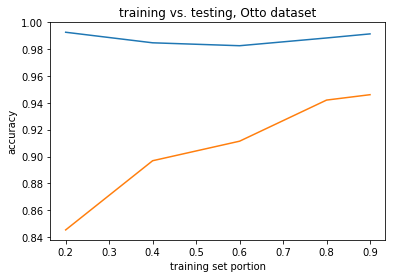

In [42]:
# Effect of training and testing split
# EEG
training_per = [0.2,0.4,0.6,0.8,0.9]
train_score, test_score = [], []
for tr in training_per:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, train_size=tr, random_state=RANDOM_SEED)
    DNN2 = create_neural_net(category=1, dim=Xtrain.shape[1])
    DNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    DNN2.fit(Xtrain, ytrain, epochs=600, batch_size=10000, validation_data=(Xtest, ytest))
    train_score.append(DNN2.history.history['acc'][-1])
    test_score.append(DNN2.history.history['val_acc'][-1])

plt.plot(training_per,train_score, label='training accuracy')
plt.plot(training_per,test_score, label='testing accuracy')
plt.xlabel('training set portion')
plt.ylabel('accuracy')
plt.title('training vs. testing, EEG dataset')
plt.show()